# MBAN 5110 A - PREDICTIVE MODELLING Hackathon Code file
#### MMAI Group 16

Authors:
* Runze Liang     : 220292181
* Runze Xu        : 220682498
* Sushmit Richard : 220105599

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime


In [124]:
np.random.seed(42)
df=pd.read_csv("data_set_hackathon.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


In [125]:
df.head(10)

order_date requested_delivery_date Customer Country Code Product Code   
0  13.07.2009              28.01.2010                    RU    L10705000  \
1  15.07.2009              24.03.2010                    RU    L10705000   
2  16.07.2009              04.02.2010                    RU    L10705000   
3  17.07.2009              04.02.2010                    RU    L10705000   
4  21.07.2009              01.02.2010                    RU    L10705000   
5  20.07.2009              01.02.2010                    RU    L10705000   
6  20.07.2009              28.01.2010                    RU    L10705000   
7  20.07.2009              01.02.2010                    RU    L10705000   
8  21.07.2009              04.02.2010                    RU    L10705000   
9  21.07.2009              01.02.2010                    RU    L10705000   

                   Description order_type  Customer Order Code     value Curr   
0  Parka Outdoor Lifestyle STD         VO           3200435553   2337.00  RUB  \
1  Parka Outdoor Lifestyle STD         VO           3200435694  10160.25  RUB   
2  Parka Outdoor Lifestyle STD         VO           3200435741   2992.50  RUB   
3  Parka Outdoor Lifestyle STD         VO           3200435907   4061.25  RUB   
4  Parka Outdoor Lifestyle STD         VO           3200435963   2208.75  RUB   
5  Parka Outdoor Lifestyle STD         VO           3200435982   2173.12  RUB   
6  Parka Outdoor Lifestyle STD         VO           3200436075   3344.00  RUB   
7  Parka Outdoor Lifestyle STD         VO           3200436082   3158.75  RUB   
8  Parka Outdoor Lifestyle STD         VO           3200436158   7068.00  RUB   
9  Parka Outdoor Lifestyle STD         VO           3200436332   2550.75  RUB   

  items   Route  
0     6  RU0001  
1    23  RU0001  
2     7  RU0001  
3     9  RU0001  
4     5  RU0001  
5     5  RU0001  
6     8  RU0001  
7     7  RU0001  
8    16  RU0001  
9     6  RU0001

# PART 1 - Seasonal Choice Model

## EDA -1

In [126]:
# Duplicate, Missing values and Unique values Check
missing_values = df.isnull().sum()
duplicated  = df.duplicated().sum()
datatypes  = df.dtypes
unqiue = df.nunique()

columns  = pd.DataFrame({
    "missing_values":missing_values,
    "duplicated":duplicated,
    "datatypes":datatypes,
    "unqiue":unqiue,
})
columns

missing_values  duplicated datatypes  unqiue
order_date                            0           3    object     249
requested_delivery_date               0           3    object     180
Customer Country Code                 0           3    object      31
Product Code                          0           3    object      40
Description                           0           3    object       1
order_type                            0           3    object       1
Customer Order Code                   0           3     int64     989
value                                 0           3   float64     765
Curr                                  0           3    object       9
items                                 0           3    object      56
Route                                 0           3    object      34

It seems that we have 3 duplicated rows, no missing values and 40 unique products. The datatype of `items` is string but we need to change it to an integer. We will investigate further.

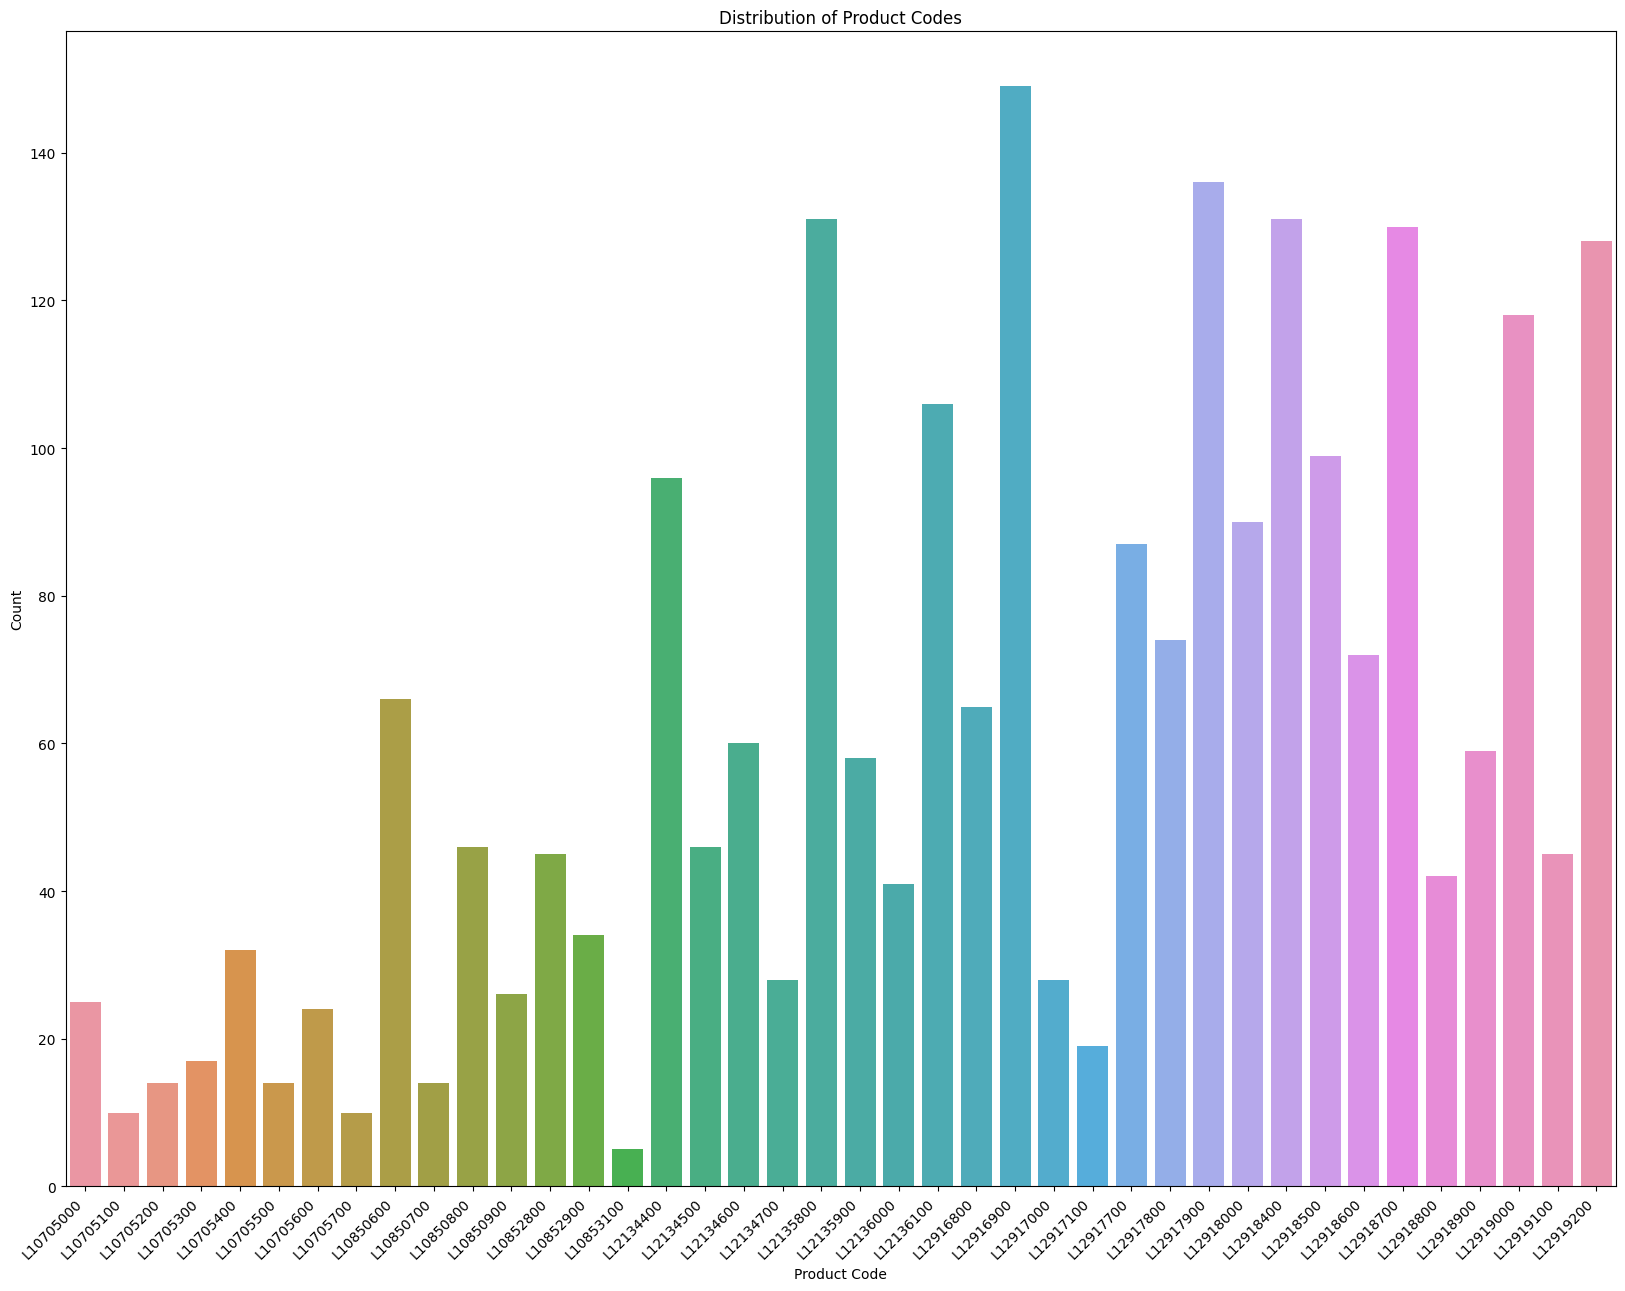

In [127]:
# Display the distribution of 'Product Code'
plt.figure(figsize=(20, 15))
sns.countplot(x='Product Code', data=df)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Product Code')
plt.ylabel('Count')
plt.title('Distribution of Product Codes')

# Show the plot
plt.show()

Just looking at the raw data, we can see the number of products distributed accross different product codes is not uniformly distributed

In [128]:
# Identifying rows with non-numeric 'items'
non_numeric_items_original = df[~df['items'].str.isnumeric()]
non_numeric_items_original

order_date requested_delivery_date Customer Country Code Product Code   
23    07.09.2009              01.04.2010                    NL    L10705000  \
24    08.09.2009              01.04.2010                    ES    L10705000   
89    03.08.2009              03.05.2010                    FR    L10705400   
90    27.08.2009              01.02.2010                    FR    L10705400   
91    06.10.2009              15.04.2010                    NL    L10705400   
...          ...                     ...                   ...          ...   
2393  08.09.2011              30.06.2012                    FI    L12919200   
2396  25.09.2011              01.05.2012                    FR    L12919200   
2399  27.09.2011              01.04.2012                    ES    L12919200   
2400  28.09.2011              01.03.2012                    IT    L12919200   
2402  30.11.2011              15.01.2012                    BE    L12919200   

                      Description order_type  Customer Order Code  value Curr   
23    Parka Outdoor Lifestyle STD         VO           3200516115    0.0  EUR  \
24    Parka Outdoor Lifestyle STD         VO           3200521379    0.0  EUR   
89    Parka Outdoor Lifestyle STD         VO           3200516117    0.0  EUR   
90    Parka Outdoor Lifestyle STD         VO           3200516182    0.0  EUR   
91    Parka Outdoor Lifestyle STD         VO           3200516289    0.0  EUR   
...                           ...        ...                  ...    ...  ...   
2393  Parka Outdoor Lifestyle STD         VO           3200746610    0.0  EUR   
2396  Parka Outdoor Lifestyle STD         VO           3200757495    0.0  EUR   
2399  Parka Outdoor Lifestyle STD         VO           3200759344    0.0  EUR   
2400  Parka Outdoor Lifestyle STD         VO           3200759628    0.0  EUR   
2402  Parka Outdoor Lifestyle STD         VO           3200795527    0.0  EUR   

     items   Route  
23      \N  BE0001  
24      \N  SP0003  
89      \N  FR0001  
90      \N  FR0001  
91      \N  BE0001  
...    ...     ...  
2393    \N  FI01FR  
2396    \N  FR0001  
2399    \N  SP0003  
2400    \N  IT0000  
2402    \N  BE0001  

[346 rows x 11 columns]

We can see that that there are some rows with value \N in the `items` column. Their corresponding data in the `value` column is also 0. But we will first count the number of such rows.

In [129]:
# Counting the number of rows where the 'value' column is equal to 0 in the original dataset
zero_value_count = df[df['value'] == 0].shape[0]
zero_value_count

345

Although there are 346 rows with `items` as \N , there are only 345 rows that have 0 in the value column. So, we will remove the rows with `items` as \N.

In [133]:
#Dropping those values
# Replace '\N' with NaN and then drop rows with NaN in the 'items' column
df['items'] = df['items'].replace('\\N', pd.NA)
df = df.dropna(subset=['items'])

# If you want to reset the index after dropping rows
df = df.reset_index(drop=True)

In [135]:
# Checking again to see we did not miss any row with such values
non_numeric_items_original = df[~df['items'].str.isnumeric()]
non_numeric_items_original

Empty DataFrame
Columns: [order_date, requested_delivery_date, Customer Country Code, Product Code, Description, order_type, Customer Order Code, value, Curr, items, Route]
Index: []

In [136]:
# Checking again for the number of rows where the 'value' column is equal to 0
zero_value_count = df[df['value'] == 0].shape[0]
zero_value_count

0

In [137]:
# DataType Conversions
df['items'] = df['items'].astype(int)
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')

In [139]:
# Feature engineering
# Extract month and day of the week from 'order_date' and 'Requested Delivery Date'
df['OrderMonth'] = df['order_date'].dt.month
df['OrderDayOfWeek'] = df['order_date'].dt.dayofweek
df['DeliveryMonth'] = df['requested_delivery_date'].dt.month
df['Shipping Duration'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Mapping months to seasons (Based on Delivery month since we want to know in which season demand are highest)
season_mapping = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
df['Season'] = df['DeliveryMonth'].map(season_mapping)

In [140]:
# Dropping Duplicates
df = df.drop_duplicates()
# Dropping Unnecessary Columns
df = df.drop(['order_type','Customer Order Code','Description'], axis=1)  

In [141]:
#re-ordering columns (to put target variable column at the end)
desired_columns = [col for col in df.columns if col != 'Product Code'] + ['Product Code']
# Reorder the DataFrame columns
df = df[desired_columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2072 entries, 0 to 2073
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2072 non-null   datetime64[ns]
 1   requested_delivery_date  2072 non-null   datetime64[ns]
 2   Customer Country Code    2072 non-null   object        
 3   value                    2072 non-null   float64       
 4   Curr                     2072 non-null   object        
 5   items                    2072 non-null   int32         
 6   Route                    2072 non-null   object        
 7   OrderMonth               2072 non-null   int32         
 8   OrderDayOfWeek           2072 non-null   int32         
 9   DeliveryMonth            2072 non-null   int32         
 10  Shipping Duration        2072 non-null   int64         
 11  Season                   2072 non-null   object        
 12  Product Code             2072 non-null 

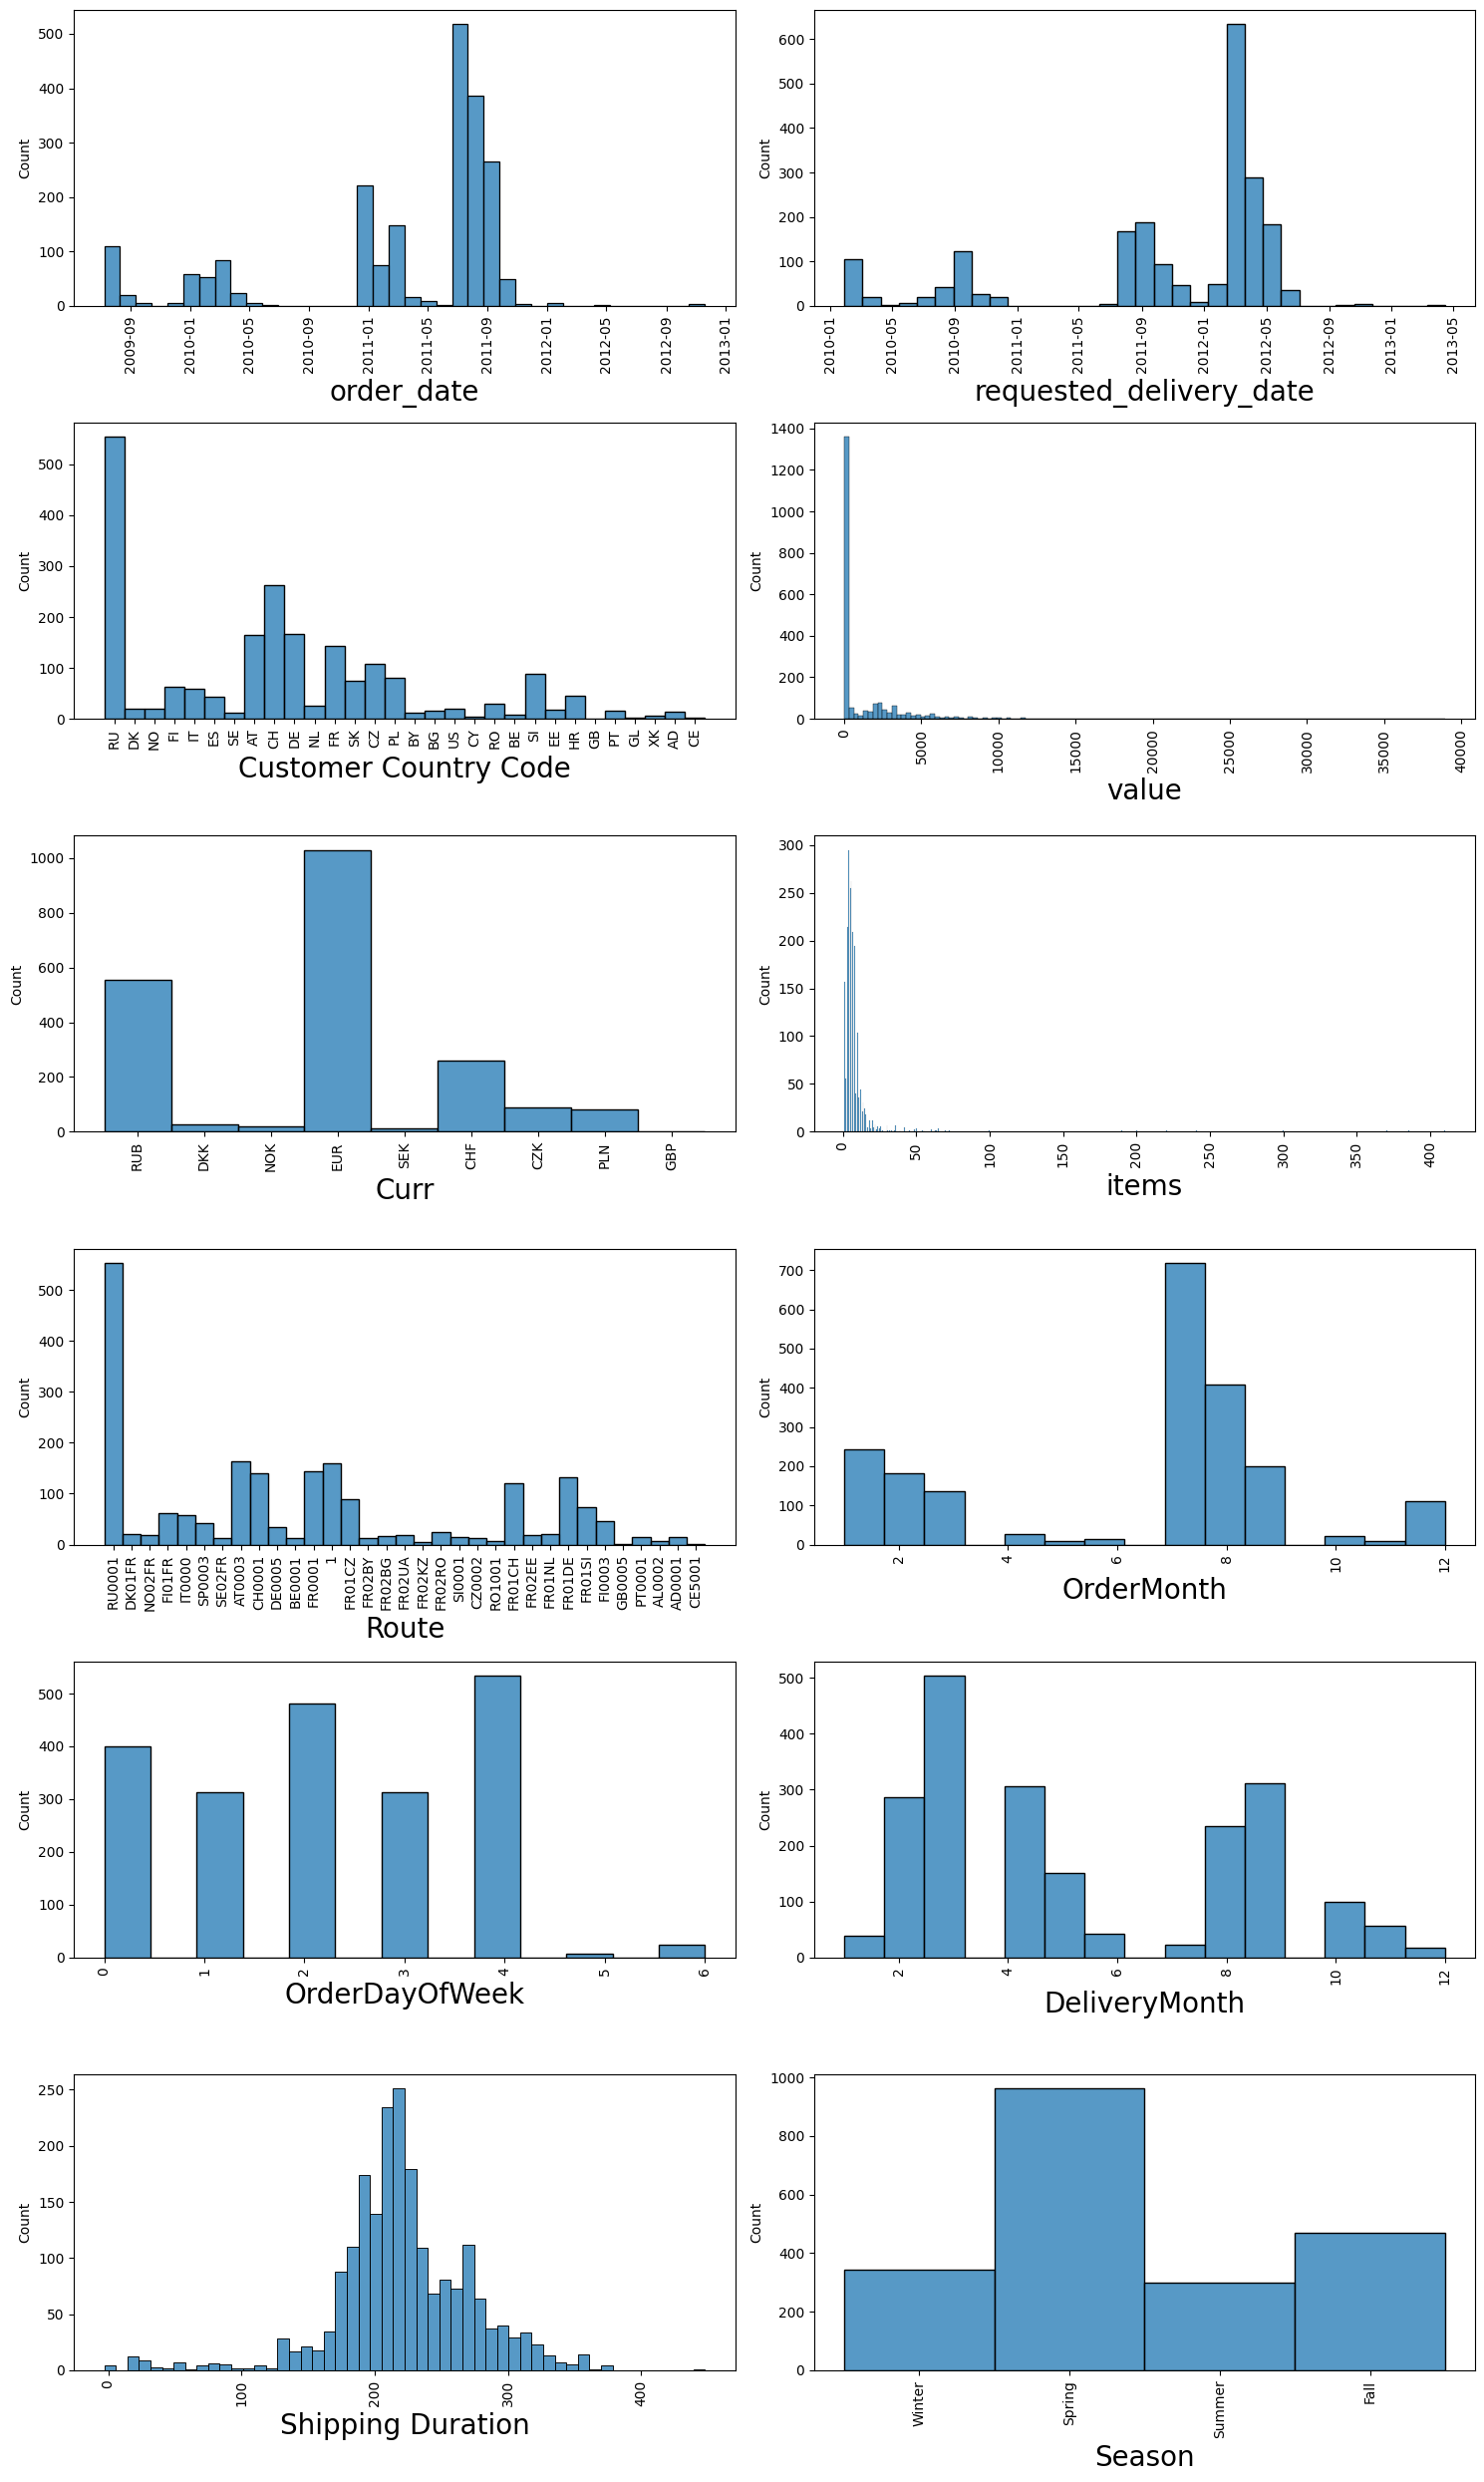

In [142]:
# Plotting Distribution of other variables

data = df.iloc[:, :-1] # exclude the last column because it is the target
num_cols = data.shape[1]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 25))
axes = axes.flatten()

# Iterating over each column
for i, col in enumerate(data.columns):
    ax = axes[i]
    sns.histplot(x=data[col], ax=ax)
    ax.set_xlabel(col,fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
# Adjusting the spacing between subplots
plt.tight_layout()

# Displaying the plot
plt.show()

## Numeric Variable Analysis

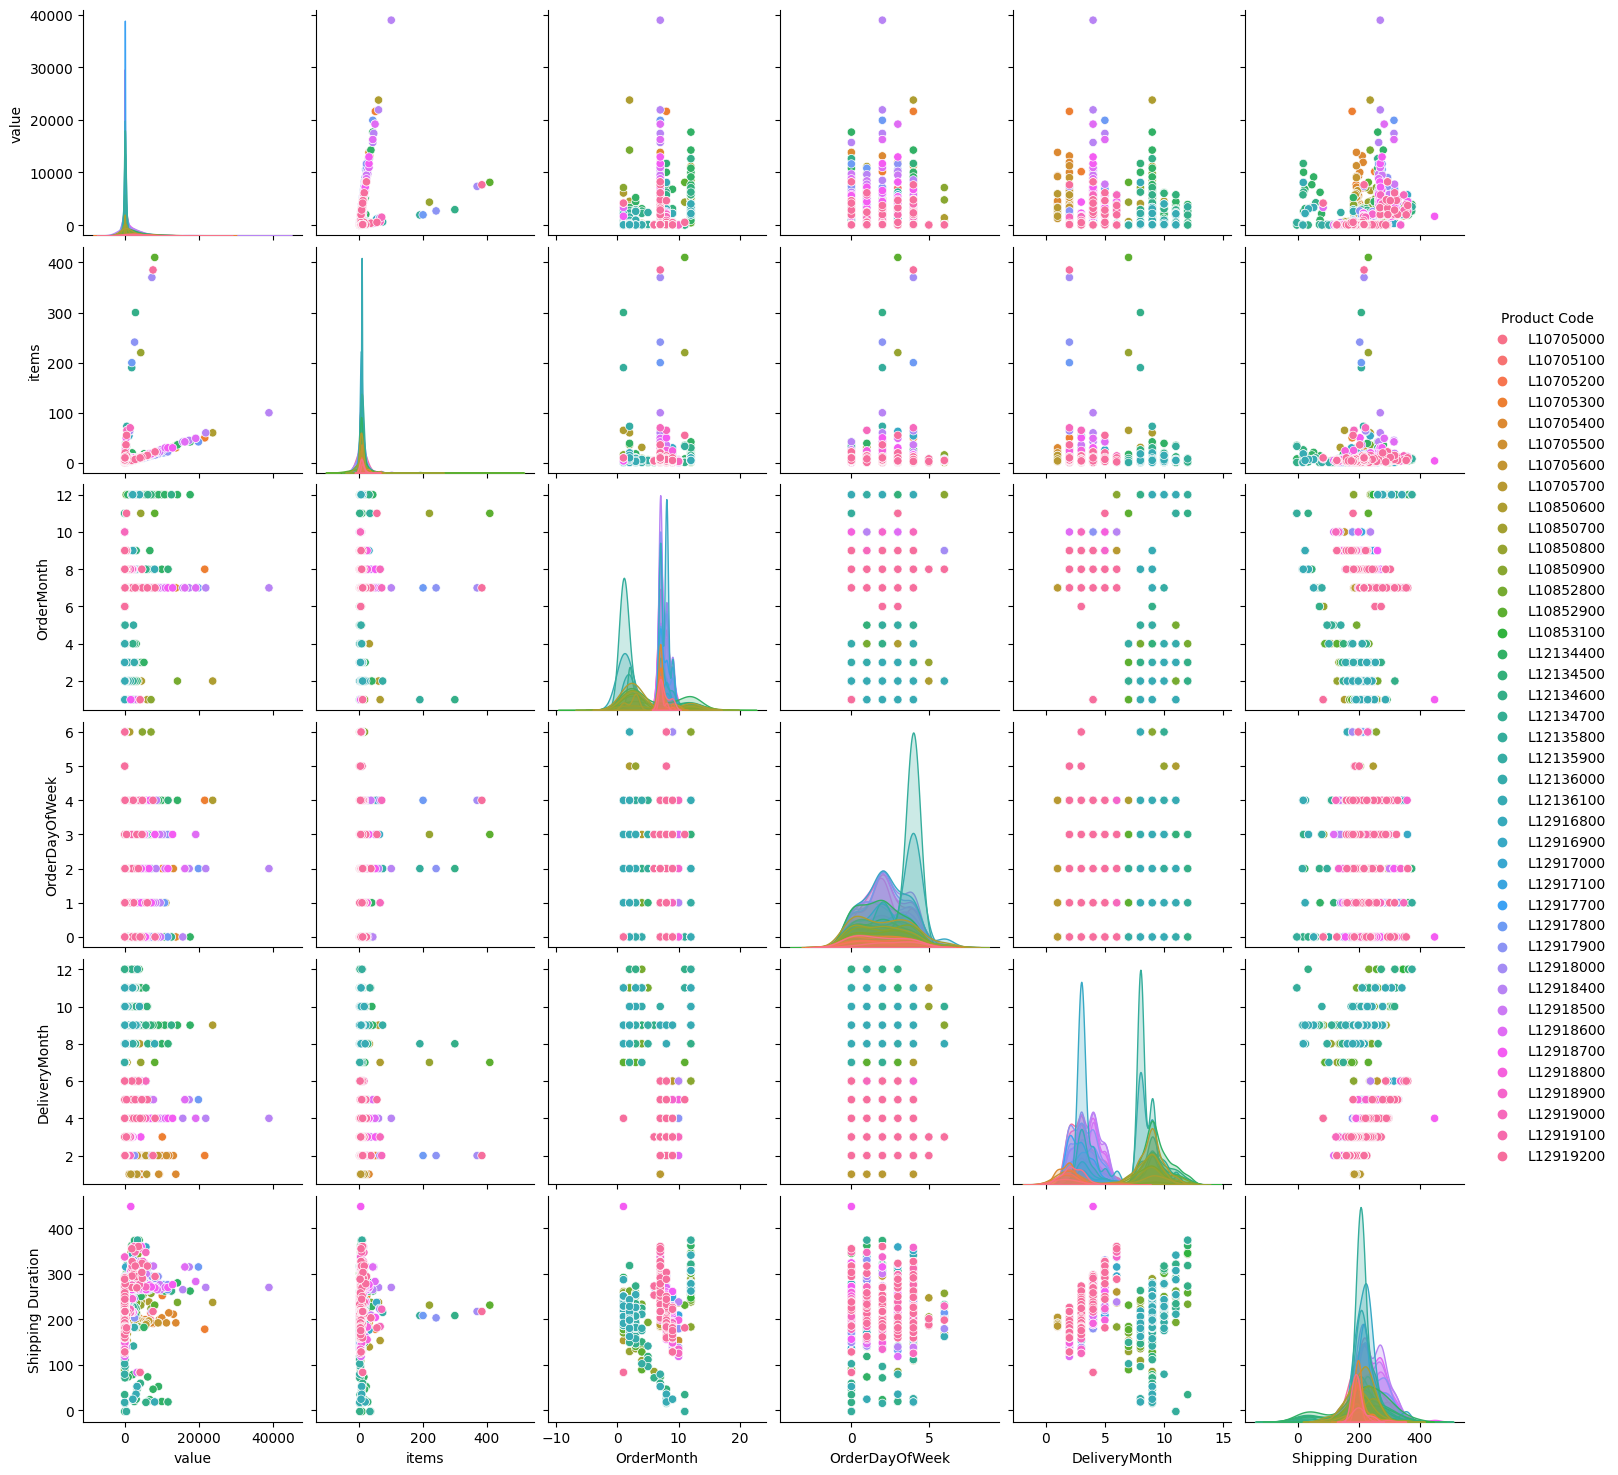

In [143]:
# More detailed exploration for each Product Type
sns.pairplot(df, hue='Product Code')
plt.show()

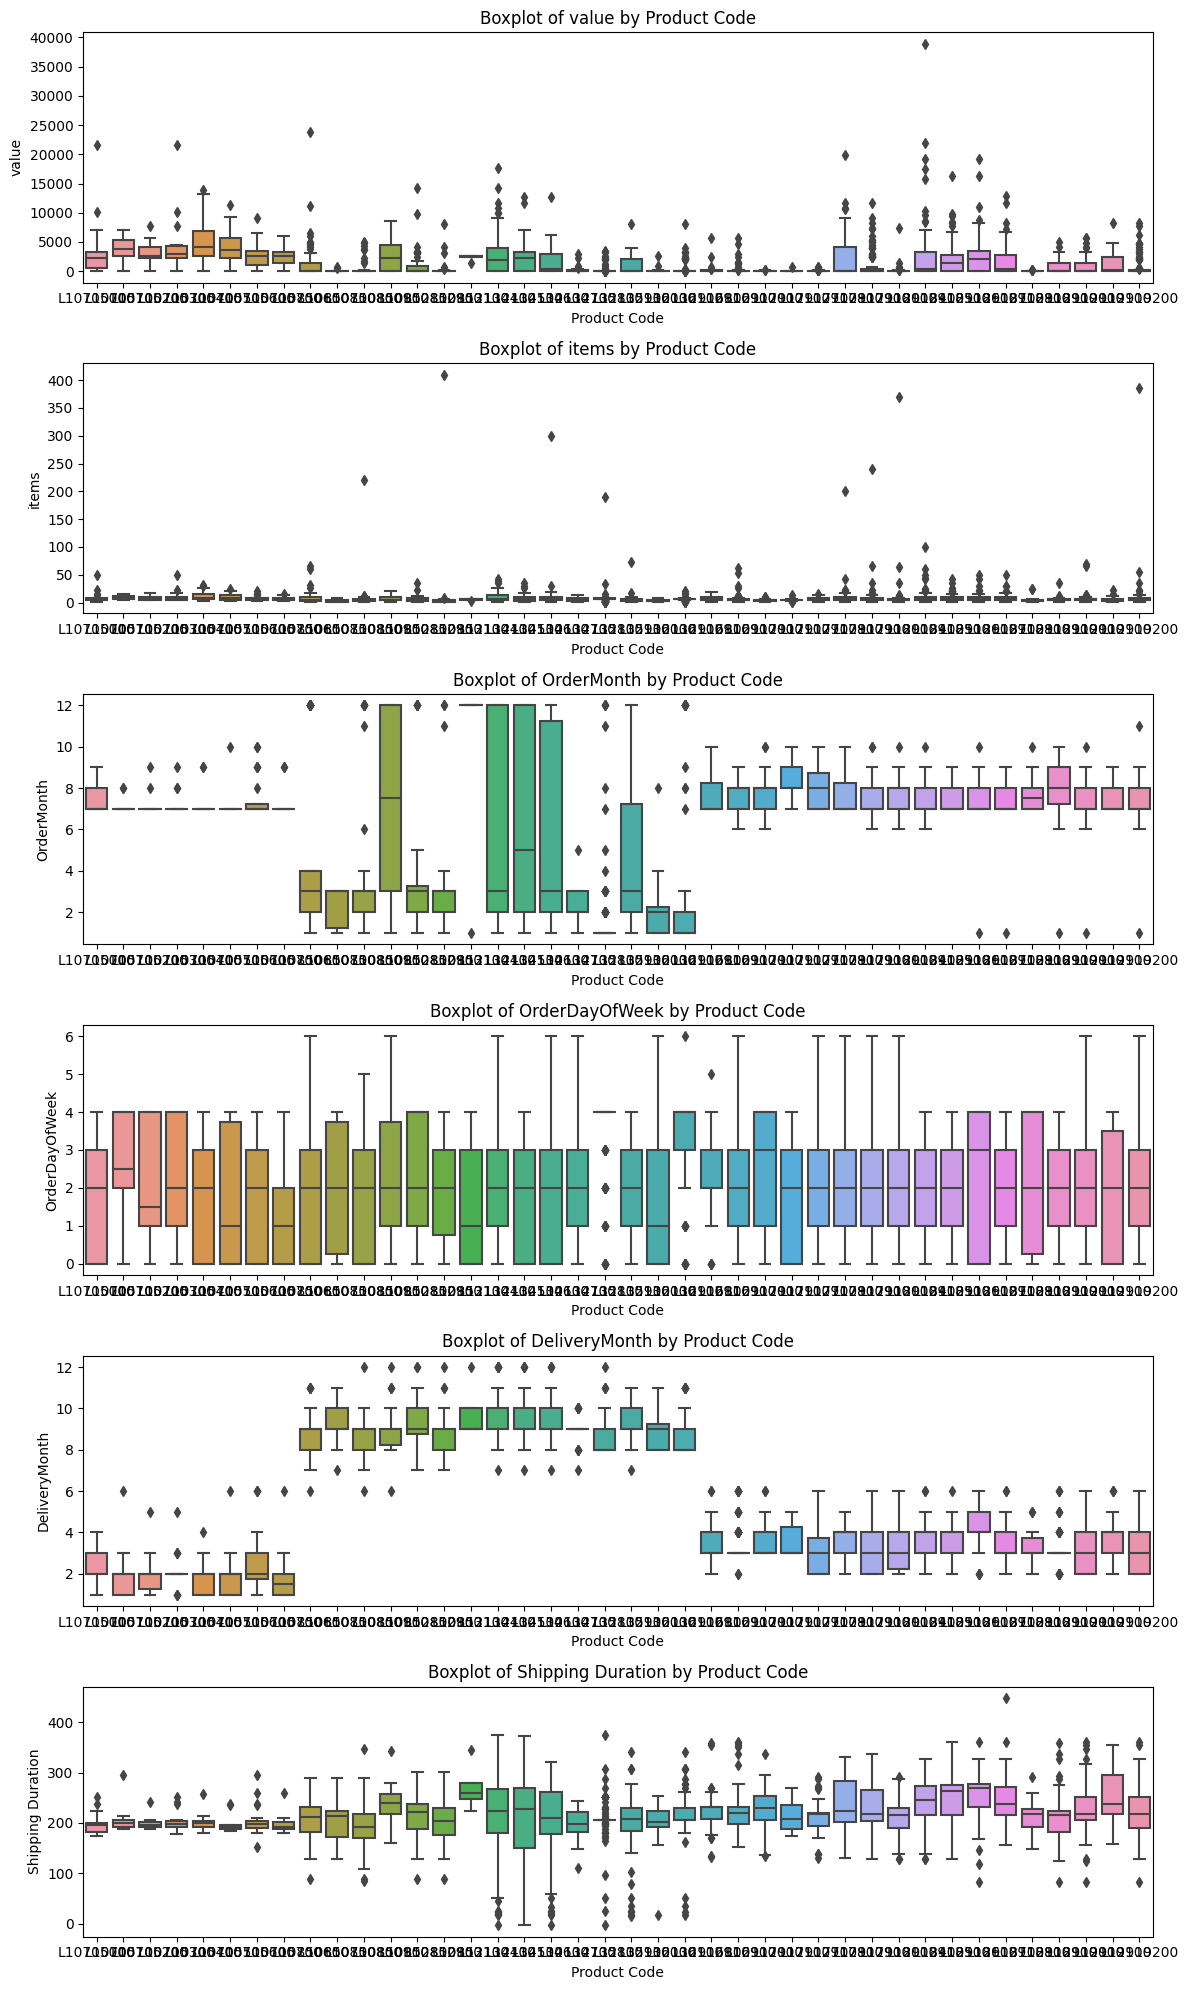

In [144]:
fig, axs = plt.subplots(6, 1, figsize=(12, 20))  
numerical_columns = df.select_dtypes(include=[np.number])  # select all numerical columns
for i, feature in enumerate(numerical_columns):
    sns.boxplot(x='Product Code', y=feature, data=df, ax=axs[i])
    axs[i].set_title(f'Boxplot of {feature} by Product Code')

# Adjust space between subplots
plt.subplots_adjust(hspace=5)

plt.tight_layout()
plt.show()

We can see that only `OrderMonth` and `DeliveryMonth` are the variables that cause the counts of different product codes to vary considerably.

**Therefore, the important numerical variables selected for the model are `OrderMonth` and `DeliveryMonth`.**

## Categorical Variable Analysis

In [145]:
non_numerical_columns = df.select_dtypes(exclude=['number']).dtypes
non_numerical_columns 

order_date                 datetime64[ns]
requested_delivery_date    datetime64[ns]
Customer Country Code              object
Curr                               object
Route                              object
Season                             object
Product Code                       object
dtype: object

In [146]:
#Selected Categorical Variables for further analysis
cat_columns = ['Customer Country Code','Curr','Route','Season']

In [147]:
from scipy.stats import chi2_contingency

# Create a contingency table for each categorical feature with the target
for column in cat_columns:
    contingency_table = pd.crosstab(df[column], df['Product Code'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    print(f"Chi-square test for independence between {column} and Product Code:")
    print(f"Chi2: {chi2}, p-value: {p}")
    print("")


Chi-square test for independence between Customer Country Code and Product Code:
Chi2: 3283.75233873741, p-value: 1.7972520199197269e-208

Chi-square test for independence between Curr and Product Code:
Chi2: 1454.8423268819681, p-value: 1.2173911858303786e-146

Chi-square test for independence between Route and Product Code:
Chi2: 4265.113818036323, p-value: 0.0

Chi-square test for independence between Season and Product Code:
Chi2: 2652.672955029242, p-value: 0.0



Interpretation:

1. **Customer Country Code and Product Code:**
   - **Chi2 (Chi-square statistic):** 3283.75
   - **p-value:** 1.797e-208

   **Interpretation:** The extremely low p-value (close to zero) suggests a highly significant association between Customer Country Code and Product Code. The null hypothesis of independence is strongly rejected, indicating a substantial relationship between the two variables.

2. **Currency and Product Code:**
   - **Chi2:** 1454.84
   - **p-value:** 1.217e-146

   **Interpretation:** Similarly, the very low p-value indicates a highly significant association between Currency and Product Code. The two variables are not independent; their relationship is statistically significant.

3. **Route and Product Code:**
   - **Chi2:** 4265.11
   - **p-value:** 0.0

   **Interpretation:** The p-value of 0.0 indicates an extremely significant association between Route and Product Code. The null hypothesis of independence is strongly rejected, suggesting a clear relationship between the two variables.

4. **Season and Product Code:**
   - **Chi2:** 2652.67
   - **p-value:** 0.0

   **Interpretation:** The very low p-value suggests a highly significant association between Season and Product Code. The variables are not independent; there is a statistically significant relationship.

In summary, based on these p-values, all tested pairs exhibit a highly significant association. The null hypothesis of independence is strongly rejected for each pair, indicating meaningful relationships between Customer Country Code, Currency, Route, and Season with Product Code.

<Figure size 1000x600 with 0 Axes>

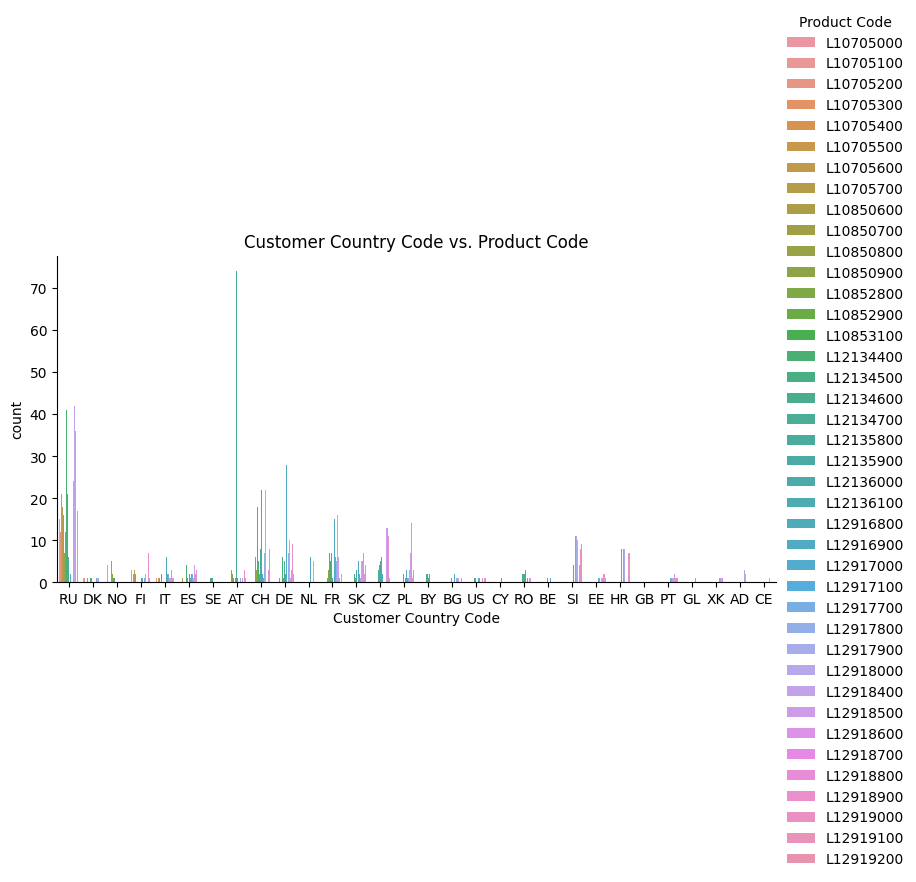

<Figure size 1000x600 with 0 Axes>

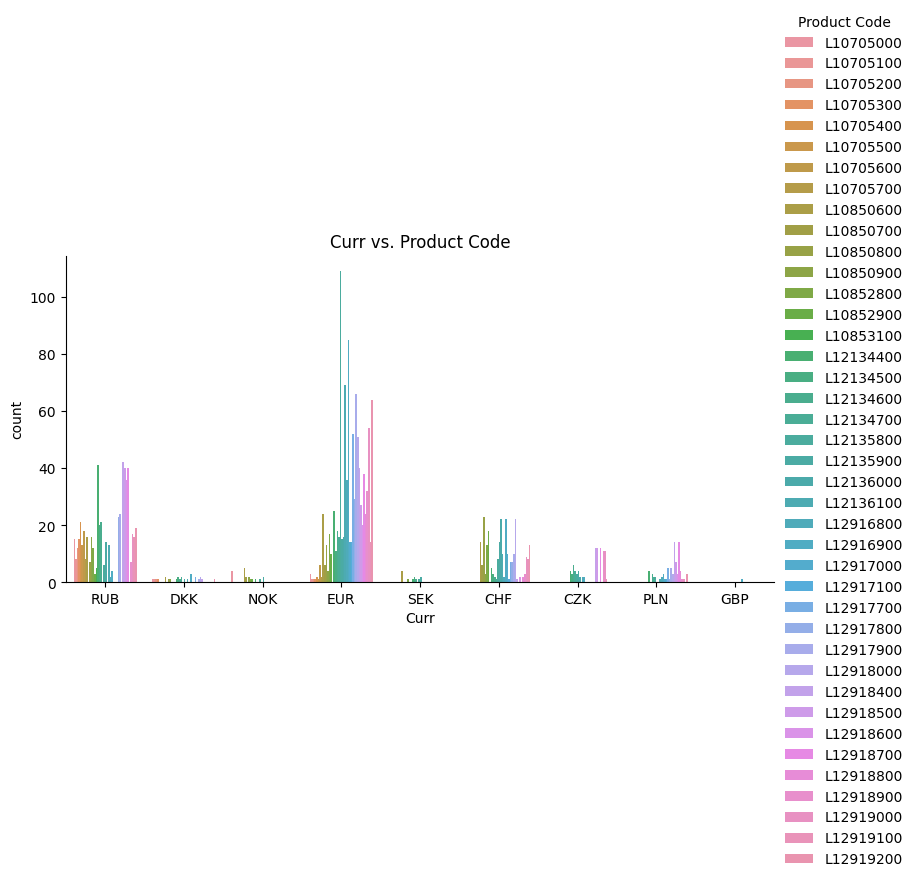

<Figure size 1000x600 with 0 Axes>

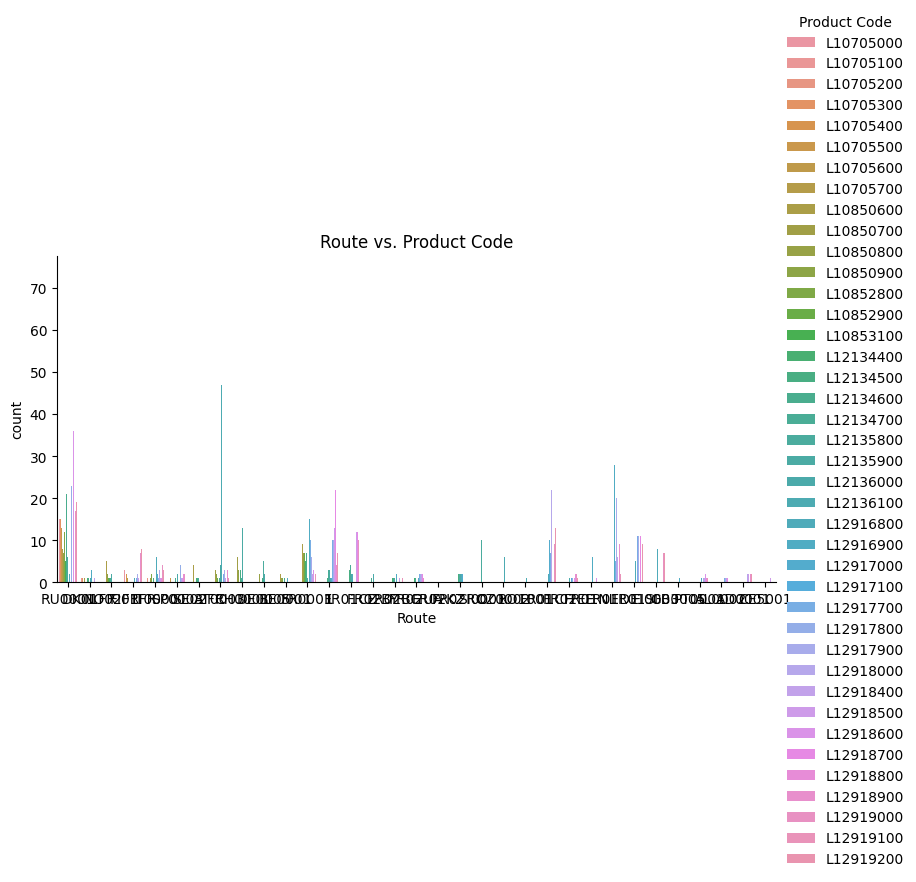

<Figure size 1000x600 with 0 Axes>

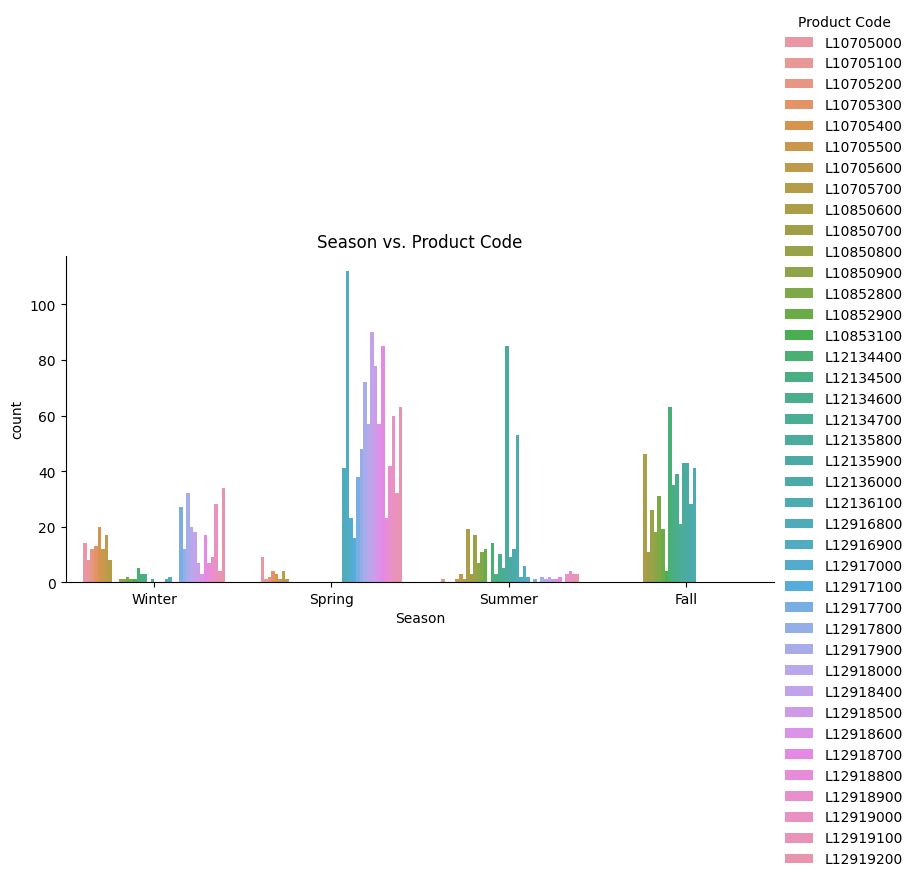

In [148]:
# Plotting catplot for selected categorical feature with the target
for column in cat_columns:
    plt.figure(figsize=(10, 6))
    sns.catplot(x=column, hue='Product Code', data=df, kind='count', height=4, aspect=2)
    plt.title(f"{column} vs. Product Code")
    plt.show()

Based on the Chi-Squared test and these plots,we can see that for all categorical variables cause the distribution of different poduct codes to vary considerably.

**Therefore, the important categorical variables selected for the model are `Customer Country Code`, `Curr`, `Route` and `Season`.**

### MODELLING

In [182]:
# Prepare target and features
X= df[['OrderMonth', 'DeliveryMonth','Customer Country Code', 'Curr', 'Route','Season']]
X = pd.get_dummies(X, dtype=int)
y = df['Product Code']
X

OrderMonth  DeliveryMonth  Customer Country Code_AD   
0              7              1                         0  \
1              7              3                         0   
2              7              2                         0   
3              7              2                         0   
4              7              2                         0   
...          ...            ...                       ...   
2069           7              2                         0   
2070           7              2                         0   
2071           7              2                         0   
2072           7              2                         0   
2073           1              4                         0   

      Customer Country Code_AT  Customer Country Code_BE   
0                            0                         0  \
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
2069                         0                         0   
2070                         0                         0   
2071                         0                         0   
2072                         0                         0   
2073                         0                         0   

      Customer Country Code_BG  Customer Country Code_BY   
0                            0                         0  \
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
2069                         0                         0   
2070                         0                         0   
2071                         0                         0   
2072                         0                         0   
2073                         0                         0   

      Customer Country Code_CE  Customer Country Code_CH   
0                            0                         0  \
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
2069                         0                         0   
2070                         0                         0   
2071                         0                         0   
2072                         0                         0   
2073                         0                         0   

      Customer Country Code_CY  ...  Route_PT0001  Route_RO1001  Route_RU0001   
0                            0  ...             0             0             1  \
1                            0  ...             0             0             1   
2                            0  ...             0             0             1   
3                            0  ...             0             0             1   
4                            0  ...             0             0             1   
...                        ...  ...           ...           ...           ...   
2069                         0  ...             0             0             0   
2070                         0  ...             0             0             0   
2071                         0  ...             0             0             0   
2072                         0  ...             0             0             0   
2073                         0  ...             0             0             1   

      Route_SE02FR  Route_SI0001  Route_SP0003  Season_Fall  Season_Spring   
0                0             0             0            0

In [183]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [210]:
# Train Logistic Regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs')  # For multiple classes
log_reg.fit(X_train, y_train)

# Fit The model
y_pred_lr = log_reg.predict(X_test)


### Model Evaluation

In [211]:
#Logistics Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Model Accuracy: {accuracy_lr}')

# Display classification report
print(classification_report(y_test, y_pred_lr))

Model Accuracy: 0.1783132530120482
              precision    recall  f1-score   support

   L10705000       0.00      0.00      0.00         0
   L10705100       0.00      0.00      0.00         5
   L10705200       0.00      0.00      0.00         2
   L10705300       0.00      0.00      0.00         4
   L10705400       0.00      0.00      0.00         6
   L10705500       0.00      0.00      0.00         2
   L10705600       0.08      0.17      0.11         6
   L10705700       0.00      0.00      0.00         1
   L10850600       0.18      0.30      0.22        10
   L10850700       0.00      0.00      0.00         4
   L10850800       0.27      0.40      0.32        10
   L10850900       0.00      0.00      0.00         3
   L10852800       0.10      0.08      0.09        12
   L10852900       0.00      0.00      0.00         7
   L10853100       0.00      0.00      0.00         1
   L12134400       0.27      0.63      0.38        19
   L12134500       0.00      0.00      0.00   

### Model Interpretation:

**Model Accuracy: 0.1783 (17.83%)**

The overall accuracy of the model is approximately 17.83%. This indicates that the model's ability to correctly predict the class labels is relatively low.

#### Class-specific Performance:

- **Precision:** Precision measures the accuracy of the positive predictions. It is the ratio of true positive predictions to the total predicted positives.

- **Recall:** Recall, or sensitivity, measures the ability of the model to capture all the true positives. It is the ratio of true positive predictions to the total actual positives.

- **F1-Score:** The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of a model's performance.

#### Strategic Recommendations:

1. **Class L10705000:**
   - No predictions for this class. Further investigation is needed to understand why this class is not captured by the model.

2. **Imbalanced Classes:**
   - Some classes have very low precision, recall, and F1-scores. Consider addressing class imbalance through techniques like oversampling or undersampling to improve the model's ability to predict minority classes.

3. **High Precision and Recall for Class L12135800:**
   - The model performs relatively well for Class L12135800, with high precision, recall, and F1-score. Further analysis can be done to understand the characteristics of this class and potentially replicate strategies for other classes.

4. **Low Macro and Weighted Averages:**
   - The macro and weighted averages for precision, recall, and F1-score are low. This indicates that the model struggles to generalize across all classes.

### Business/Strategic Recommendations:

1. **Improve Data Quality:**
   - Investigate and address missing data or anomalies in the dataset, especially for Class L10705000 where no predictions are made.

2. **Address Class Imbalance:**
   - Implement strategies to address imbalanced classes, such as oversampling, undersampling, or using techniques like SMOTE (Synthetic Minority Over-sampling Technique).

3. **Feature Engineering:**
   - Explore the possibility of creating new features that might enhance the model's ability to discriminate between classes.

4. **Model Tuning:**
   - Experiment with different machine learning algorithms and hyperparameter tuning to find a model that better fits the data and improves overall accuracy.

5. **Class-specific Strategies:**
   - Analyze classes with low precision, recall, and F1-score individually. Understand the business context for these classes and consider collecting more relevant data or adjusting the model approach.

6. **Continuous Monitoring:**
   - Implement a system for continuous monitoring and evaluation of the model's performance. Regularly update the model based on new data and evolving business requirements.

7. **Collaboration with Domain Experts:**
   - Collaborate with domain experts to gain insights into the business context, understand the importance of different classes, and refine the model accordingly.

By addressing these recommendations, the model's accuracy and effectiveness in predicting class labels can be improved, leading to more reliable and valuable outcomes for the business.



### Calculating Choice Probablities

In [187]:
# Predict probabilities for each class
probabilities = log_reg.predict_proba(X_test)
# Getting the classes (product codes) from the model
product_codes = log_reg.classes_
# Create a DataFrame to store probabilities with corresponding product codes
probabilities_df = pd.DataFrame(probabilities, columns=product_codes)
probabilities_df.head()

L10705000     L10705100     L10705200     L10705300     L10705400   
0  5.407700e-03  7.173415e-04  7.854308e-04  1.317286e-03  1.372811e-03  \
1  8.754552e-11  1.895435e-10  8.014818e-08  9.985533e-09  6.861522e-09   
2  6.961498e-12  1.390359e-11  1.184393e-08  1.205172e-09  7.345080e-10   
3  7.573264e-03  6.990592e-04  8.233799e-04  1.400409e-03  1.530740e-03   
4  1.127672e-09  2.583014e-09  5.216121e-07  8.258423e-08  5.871516e-08   

      L10705500     L10705600     L10705700  L10850600  L10850700  ...   
0  4.457002e-04  8.099945e-04  1.351398e-03   0.000338   0.000244  ...  \
1  3.788807e-09  3.394988e-07  2.642774e-08   0.027863   0.012407  ...   
2  4.054875e-10  5.621596e-08  3.261260e-09   0.120225   0.017510  ...   
3  4.298048e-04  9.719164e-04  1.448539e-03   0.000049   0.000059  ...   
4  3.649403e-08  4.519165e-06  3.386204e-07   0.210114   0.018350  ...   

   L12918000  L12918400  L12918500  L12918600  L12918700  L12918800   
0   0.167896   0.004661   0.004397   0.022748   0.004397   0.009149  \
1   0.000272   0.001408   0.000878   0.000529   0.000455   0.000807   
2   0.000060   0.000309   0.000129   0.000085   0.000033   0.000128   
3   0.005501   0.112538   0.188981   0.005556   0.157282   0.008199   
4   0.002041   0.002375   0.002677   0.003062   0.000534   0.000433   

   L12918900  L12919000  L12919100  L12919200  
0   0.024912   0.076595   0.068912   0.064856  
1   0.000115   0.000644   0.000498   0.000627  
2   0.000052   0.000372   0.000056   0.000355  
3   0.159573   0.205173   0.015397   0.004956  
4   0.000226   0.004293   0.001456   0.003136  

[5 rows x 40 columns]

In [188]:
# Calculate mean probability for each product code
choice_probabilities = probabilities_df.mean()
choice_probabilities

L10705000    0.011486
L10705100    0.002493
L10705200    0.006334
L10705300    0.006532
L10705400    0.009019
L10705500    0.006028
L10705600    0.009717
L10705700    0.004940
L10850600    0.035639
L10850700    0.006444
L10850800    0.021791
L10850900    0.015761
L10852800    0.023516
L10852900    0.016427
L10853100    0.002790
L12134400    0.040711
L12134500    0.020243
L12134600    0.028730
L12134700    0.011230
L12135800    0.063639
L12135900    0.023129
L12136000    0.018202
L12136100    0.051487
L12916800    0.028362
L12916900    0.056850
L12917000    0.013593
L12917100    0.008702
L12917700    0.029655
L12917800    0.027107
L12917900    0.050744
L12918000    0.034464
L12918400    0.051263
L12918500    0.039394
L12918600    0.025542
L12918700    0.048065
L12918800    0.015384
L12918900    0.026562
L12919000    0.048251
L12919100    0.020494
L12919200    0.039280
dtype: float64

### Choice Probabilities for Different Classes:

The following are the choice probabilities for various classes based on the model predictions:

- **L10705000: 0.0115**
  - This class has a choice probability of approximately 1.15%. It indicates the likelihood of instances belonging to class L10705000 based on the model.

- **L10705100: 0.0025**
  - The choice probability for class L10705100 is around 0.25%. This suggests a very low likelihood of instances being classified into this category.

- **L12134400: 0.0407**
  - Class L12134400 has a choice probability of 4.07%. This indicates a relatively higher likelihood of instances falling into this class compared to others.

- **L12135800: 0.0636**
  - With a choice probability of 6.36%, class L12135800 shows a notable likelihood according to the model predictions.

- **L12916900: 0.0569**
  - Class L12916900 has a choice probability of 5.69%, suggesting a moderate likelihood based on the model's assessment.

These choice probabilities provide insights into the model's confidence in assigning instances to different classes. Higher probabilities indicate a stronger belief in the assigned class, while lower probabilities suggest uncertainty or lower confidence. 

# PART 2- Demand Estimation Model for Advance Orders

### EDA-2 (Explore Temporal Patterns and Correlations)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2072 entries, 0 to 2073
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2072 non-null   datetime64[ns]
 1   requested_delivery_date  2072 non-null   datetime64[ns]
 2   Customer Country Code    2072 non-null   object        
 3   value                    2072 non-null   float64       
 4   Curr                     2072 non-null   object        
 5   items                    2072 non-null   int32         
 6   Route                    2072 non-null   object        
 7   OrderMonth               2072 non-null   int32         
 8   OrderDayOfWeek           2072 non-null   int32         
 9   DeliveryMonth            2072 non-null   int32         
 10  Shipping Duration        2072 non-null   int64         
 11  Season                   2072 non-null   object        
 12  Product Code             2072 non-null 

In [201]:
# Create a binary variable 'Demand Urgency' (to be set as 1 if shipping duration is less than 90 days)
df['Demand Urgency'] = np.where((df['Shipping Duration'] > 1) & (df['Shipping Duration'] < 90), 1, 0)

# Counting the number of rows where the 'value' column is equal to 0 in the original dataset
d_urge_count = df[df['Demand Urgency'] == 1].shape[0]
d_urge_count

49

In [203]:
# Group demand monthly
adv_monthly_demand = df.groupby(['DeliveryMonth', 'Product Code','Demand Urgency'])['items'].mean().reset_index()
adv_monthly_demand = adv_monthly_demand.rename(columns={'items': 'Avg Monthly Demand'})
adv_monthly_demand.head(12)

DeliveryMonth Product Code  Demand Urgency  Avg Monthly Demand
0               1    L10705000               0            6.250000
1               1    L10705100               0            7.750000
2               1    L10705200               0            6.750000
3               1    L10705300               0            7.333333
4               1    L10705400               0           12.375000
5               1    L10705500               0            9.200000
6               1    L10705600               0            7.833333
7               1    L10705700               0            8.200000
8               2    L10705000               0           12.000000
9               2    L10705100               0           13.000000
10              2    L10705200               0            9.375000
11              2    L10705300               0           12.600000

In [204]:
# Merge the two dataframes on common columns
merged_df = pd.merge(df, adv_monthly_demand, on=['DeliveryMonth', 'Product Code', 'Demand Urgency'])
merged_df.columns

Index(['order_date', 'requested_delivery_date', 'Customer Country Code',
       'value', 'Curr', 'items', 'Route', 'OrderMonth', 'OrderDayOfWeek',
       'DeliveryMonth', 'Shipping Duration', 'Season', 'Product Code',
       'Demand Urgency', 'Avg Monthly Demand'],
      dtype='object')

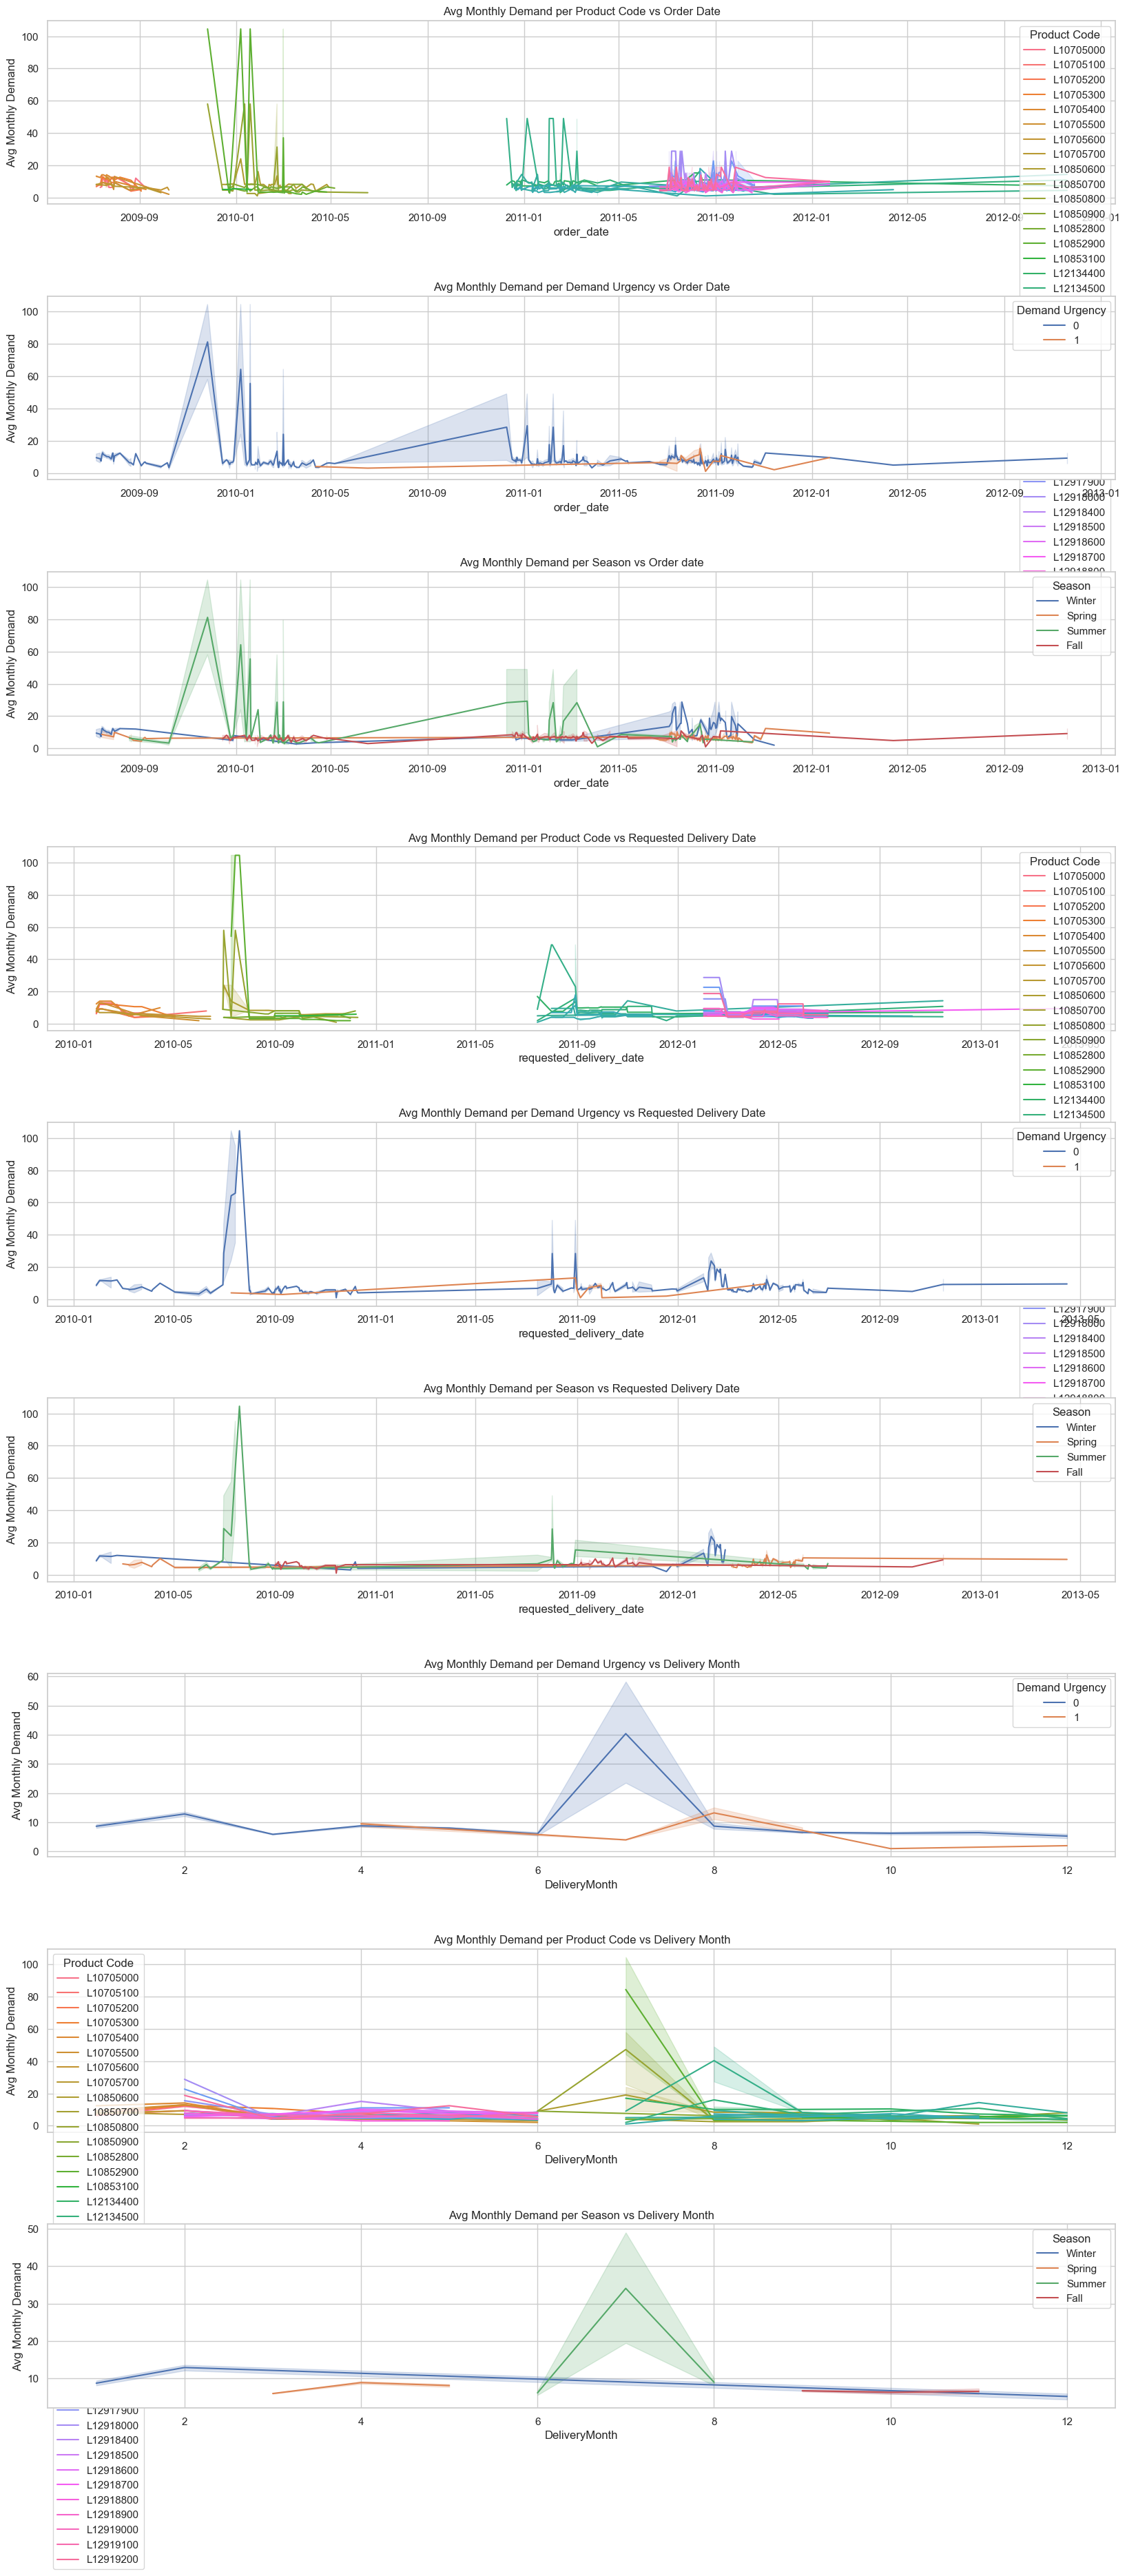

In [209]:
# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better aesthetics
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(20, 45))
fig.subplots_adjust(hspace=0.5)

# Plot variation of Avg Monthly Demand per product code vs order_date
sns.lineplot(x='order_date', y='Avg Monthly Demand', hue='Product Code', data=merged_df, ax=axes[0])
axes[0].set_title('Avg Monthly Demand per Product Code vs Order Date')

# Plot variation of Avg Monthly Demand per demand urgency vs order_date
sns.lineplot(x='order_date', y='Avg Monthly Demand', hue='Demand Urgency', data=merged_df, ax=axes[1])
axes[1].set_title('Avg Monthly Demand per Demand Urgency vs Order Date')

# Plot variation of Avg Monthly Demand per advance monthly demand vs Order Date
sns.lineplot(x='order_date', y='Avg Monthly Demand', hue='Season', data=merged_df, ax=axes[2])
axes[2].set_title('Avg Monthly Demand per Season vs Order date')

# Plot variation of Avg Monthly Demand per product code vs Requested Delivery Date
sns.lineplot(x='requested_delivery_date', y='Avg Monthly Demand', hue='Product Code', data=merged_df, ax=axes[3])
axes[3].set_title('Avg Monthly Demand per Product Code vs Requested Delivery Date')

# Plot variation of Avg Monthly Demand per demand urgency vs Requested Delivery Date
sns.lineplot(x='requested_delivery_date', y='Avg Monthly Demand', hue='Demand Urgency', data=merged_df, ax=axes[4])
axes[4].set_title('Avg Monthly Demand per Demand Urgency vs Requested Delivery Date')

# Plot variation of Avg Monthly Demand per advance monthly demand vs Requested Delivery Date
sns.lineplot(x='requested_delivery_date', y='Avg Monthly Demand', hue='Season', data=merged_df, ax=axes[5])
axes[5].set_title('Avg Monthly Demand per Season vs Requested Delivery Date')

# Plot variation of Avg Monthly Demand per Demand Urgency vs Delivery Month
sns.lineplot(x='DeliveryMonth', y='Avg Monthly Demand', hue='Demand Urgency', data=merged_df, ax=axes[6])
axes[6].set_title('Avg Monthly Demand per Demand Urgency vs Delivery Month')

# Plot variation of Avg Monthly Demand per Product Code vs Delivery Month
sns.lineplot(x='DeliveryMonth', y='Avg Monthly Demand', hue='Product Code', data=merged_df, ax=axes[7])
axes[7].set_title('Avg Monthly Demand per Product Code vs Delivery Month')

# Plot variation of Avg Monthly Demand per Season vs Delivery Month
sns.lineplot(x='DeliveryMonth', y='Avg Monthly Demand', hue='Season', data=merged_df, ax=axes[8])
axes[8].set_title('Avg Monthly Demand per Season vs Delivery Month')

# Adjust layout
plt.tight_layout()
plt.show()

### MODELLING

In [212]:
merged_df.columns

Index(['order_date', 'requested_delivery_date', 'Customer Country Code',
       'value', 'Curr', 'items', 'Route', 'OrderMonth', 'OrderDayOfWeek',
       'DeliveryMonth', 'Shipping Duration', 'Season', 'Product Code',
       'Demand Urgency', 'Avg Monthly Demand'],
      dtype='object')

In the context of SARIMA time series forecasting, the omission of dummy variables is deliberate. SARIMA inherently captures temporal patterns, rendering dummy variables unnecessary and potentially detrimental. High cardinality in categorical features can lead to increased complexity and overfitting. SARIMA's focus on chronological data allows it to naturally grasp time-related dynamics, promoting simplicity and interpretability. With the model's adeptness at capturing temporal nuances, explicit encoding of categorical variables is avoided to maintain effectiveness and streamline the forecasting process.

#### SARIMA Parameter Tuning

In the SARIMA (Seasonal AutoRegressive Integrated Moving Average) model, the parameters (p, d, q) and seasonal parameters (P, D, Q, m) play a crucial role in capturing the underlying patterns in the time series data. To find the optimal configuration for our specific dataset, we employ an automated approach using the `auto_arima` function from the `pmdarima` library. This function systematically explores a range of parameter combinations to identify the most suitable settings, ensuring the SARIMA model is well-calibrated for accurate predictions.

In [214]:
from pmdarima import auto_arima

target_variable = 'Avg Monthly Demand'
features = merged_df[['Customer Country Code','value', 'Curr', 'items', 'Route', 'OrderMonth', 'OrderDayOfWeek',
                      'DeliveryMonth', 'Shipping Duration', 'Season','Demand Urgency', 'Avg Monthly Demand']]

# Separate target variable and features
target = features[target_variable]
features = features.drop(target_variable, axis=1)

# Use auto_arima to find the optimal SARIMA parameters
auto_model = auto_arima(target, exogenous=features, seasonal=True, m=12, trace=True)

# Print the optimal SARIMA parameters
print("Optimal SARIMA Parameters:", auto_model.order, auto_model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=11471.828, Time=2.31 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=13711.805, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11511.094, Time=0.62 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12274.405, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=15668.546, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=11469.811, Time=2.72 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=11468.003, Time=0.72 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=11469.810, Time=2.20 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=11437.430, Time=0.39 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=11439.366, Time=1.08 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=11439.366, Time=2.71 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=11441.358, Time=1.56 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=11985.824, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=11498.092, Time=0.18 sec
 ARIM

In [216]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# List to store SARIMA models for each product code
sarima_models = []

# Loop through unique product codes
for product_code in merged_df['Product Code'].unique():
    # Filter data for the current product code
    product_data = merged_df[merged_df['Product Code'] == product_code]
    
    # Train-test split
    train_data, test_data = train_test_split(product_data, test_size=0.2, shuffle=False)
    
    # Define SARIMA model
    sarima_order = (3, 0, 4)  
    sarima_model = SARIMAX(train_data['Avg Monthly Demand'], order=sarima_order, seasonal_order=(0, 0, 0, 12))
    
    # Fit SARIMA model
    sarima_fit = sarima_model.fit(disp=False)
    warnings.filterwarnings('ignore')
    
    # Save the SARIMA model to the list
    sarima_models.append({'Product Code': product_code, 'Model': sarima_fit})

C:\Users\sroff\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Model Validation

Model Summary for L10705000:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   18
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -31.924
Date:                Mon, 11 Dec 2023   AIC                             79.847
Time:                        17:16:40   BIC                             86.970
Sample:                             0   HQIC                            80.829
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0901    584.077      0.000      1.000   -1144.680    1144.860
ar.L2          0.1193    728.830      0.000      1.000   -1428.361    1428.600
ar.L3          0.7672  

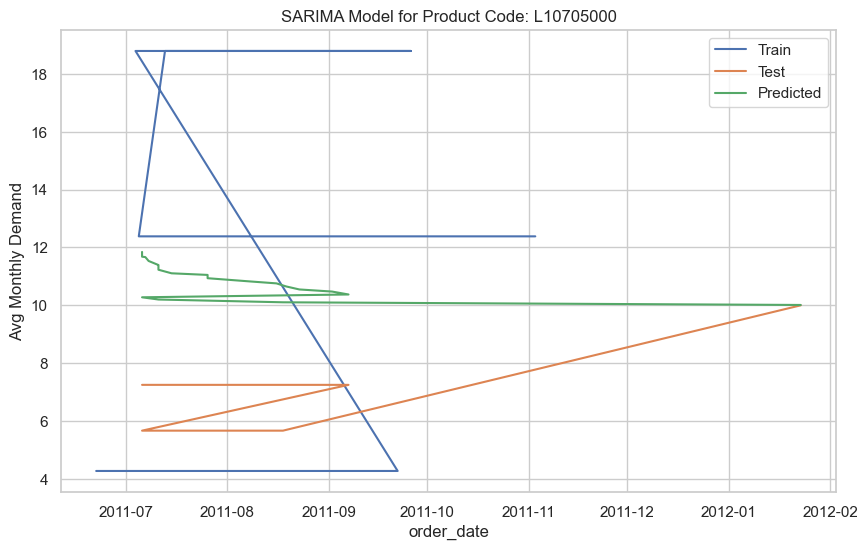

Model Summary for L10705100:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                    8
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -17.730
Date:                Mon, 11 Dec 2023   AIC                             51.459
Time:                        17:16:40   BIC                             52.095
Sample:                             0   HQIC                            47.173
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5404     19.477     -0.028      0.978     -38.716      37.635
ar.L2          0.4656     16.292      0.029      0.977     -31.467      32.398
ar.L3          0.9552  

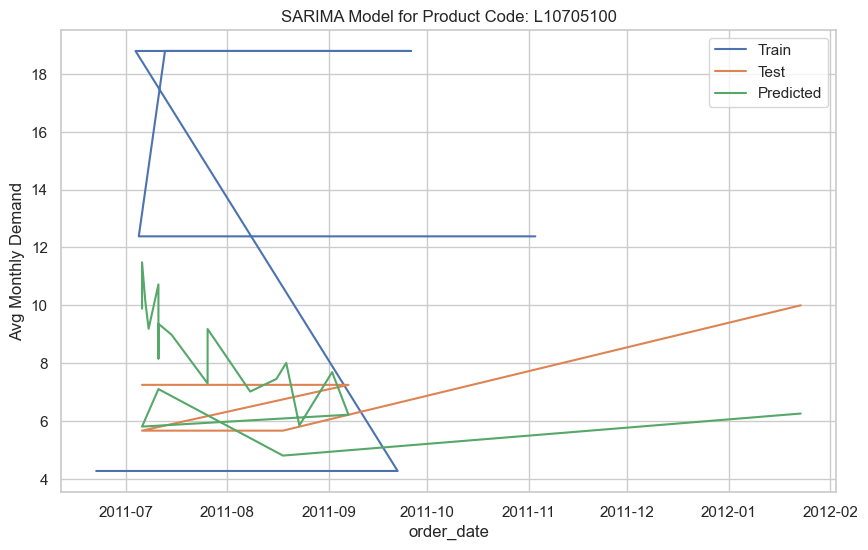

Model Summary for L10705200:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   11
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -15.834
Date:                Mon, 11 Dec 2023   AIC                             47.669
Time:                        17:16:40   BIC                             50.852
Sample:                             0   HQIC                            45.662
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2705   1662.247     -0.000      1.000   -3258.214    3257.673
ar.L2          0.5310   2768.482      0.000      1.000   -5425.593    5426.655
ar.L3          0.7238  

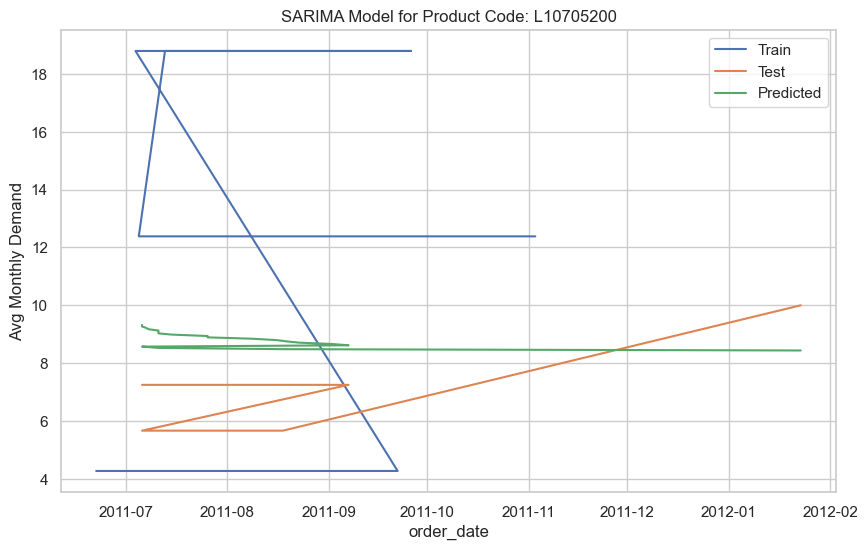

Model Summary for L10705300:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   13
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -25.618
Date:                Mon, 11 Dec 2023   AIC                             67.237
Time:                        17:16:40   BIC                             71.756
Sample:                             0   HQIC                            66.308
                                 - 13                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1107     89.989      0.012      0.990    -175.264     177.485
ar.L2          0.7315    171.721      0.004      0.997    -335.835     337.298
ar.L3         -0.8490  

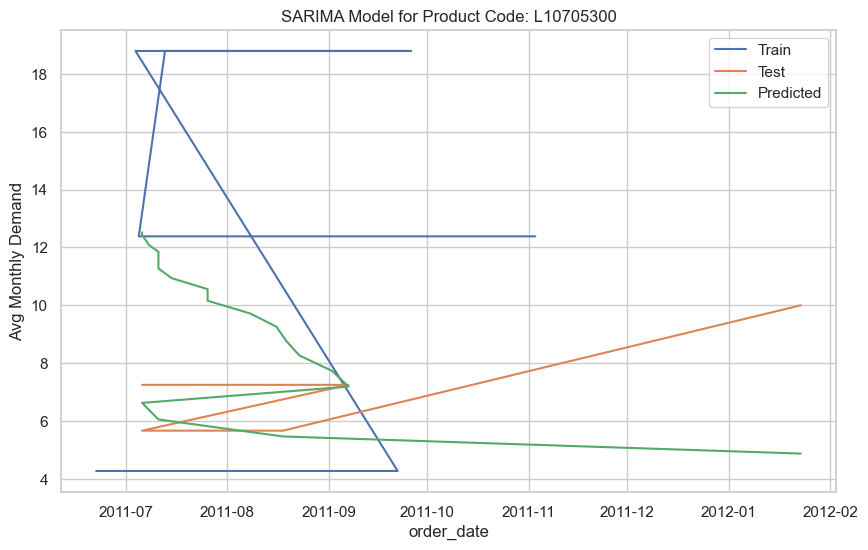

Model Summary for L10705400:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   18
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -13.145
Date:                Mon, 11 Dec 2023   AIC                             42.290
Time:                        17:16:41   BIC                             49.413
Sample:                             0   HQIC                            43.272
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5470   1.64e+04  -3.33e-05      1.000   -3.22e+04    3.22e+04
ar.L2          0.6958   8996.904   7.73e-05      1.000   -1.76e+04    1.76e+04
ar.L3          0.8495  

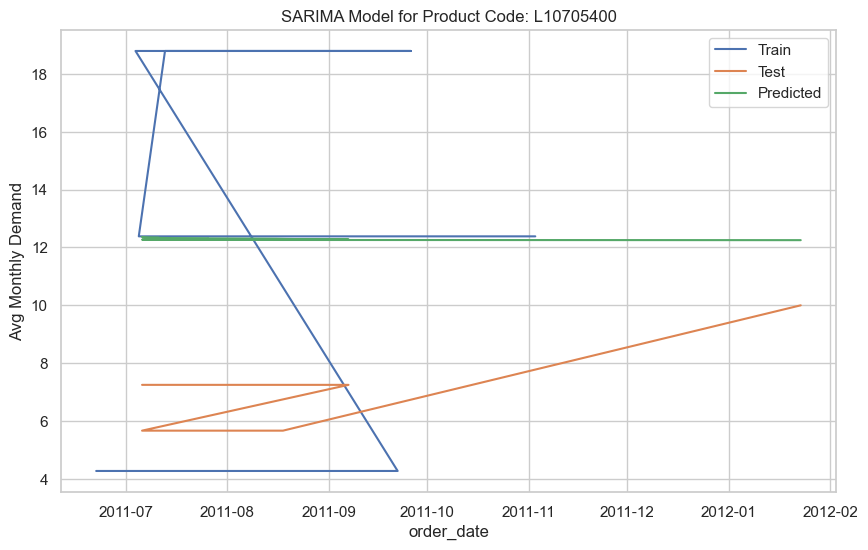

Model Summary for L10705500:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   11
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -19.508
Date:                Mon, 11 Dec 2023   AIC                             55.016
Time:                        17:16:41   BIC                             58.199
Sample:                             0   HQIC                            53.010
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7775     14.941     -0.052      0.958     -30.062      28.507
ar.L2          0.7733     15.336      0.050      0.960     -29.285      30.831
ar.L3          0.9821  

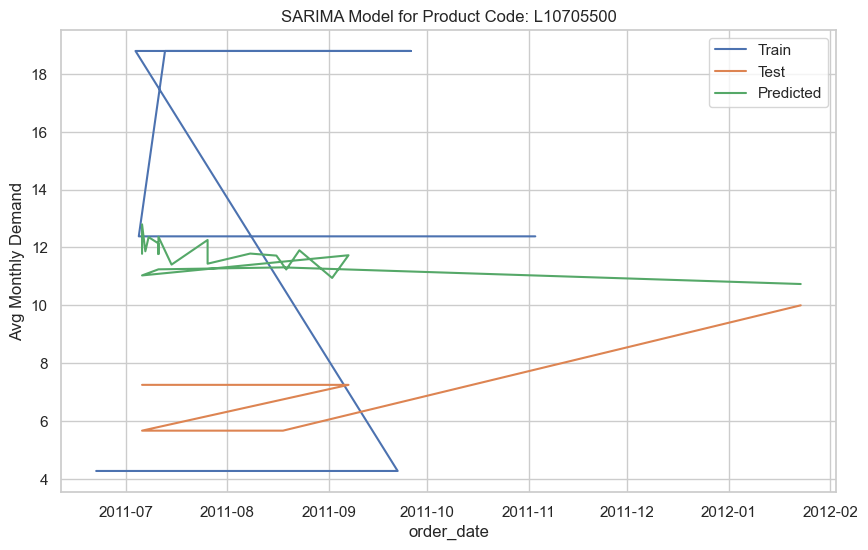

Model Summary for L10705600:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   19
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -23.143
Date:                Mon, 11 Dec 2023   AIC                             62.285
Time:                        17:16:41   BIC                             69.841
Sample:                             0   HQIC                            63.564
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2325     19.927     -0.012      0.991     -39.289      38.824
ar.L2          0.5323     14.407      0.037      0.971     -27.705      28.769
ar.L3          0.6886  

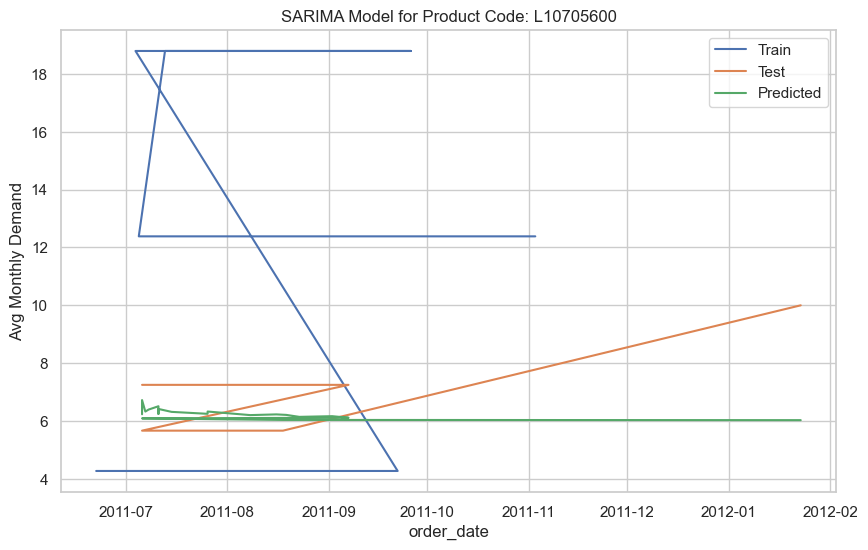

Model Summary for L10705700:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                    8
Model:               SARIMAX(3, 0, 4)   Log Likelihood                  -7.820
Date:                Mon, 11 Dec 2023   AIC                             31.640
Time:                        17:16:41   BIC                             32.276
Sample:                             0   HQIC                            27.354
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2636   1601.658     -0.000      1.000   -3139.456    3138.928
ar.L2          0.8275   8627.347   9.59e-05      1.000   -1.69e+04    1.69e+04
ar.L3          0.4301  

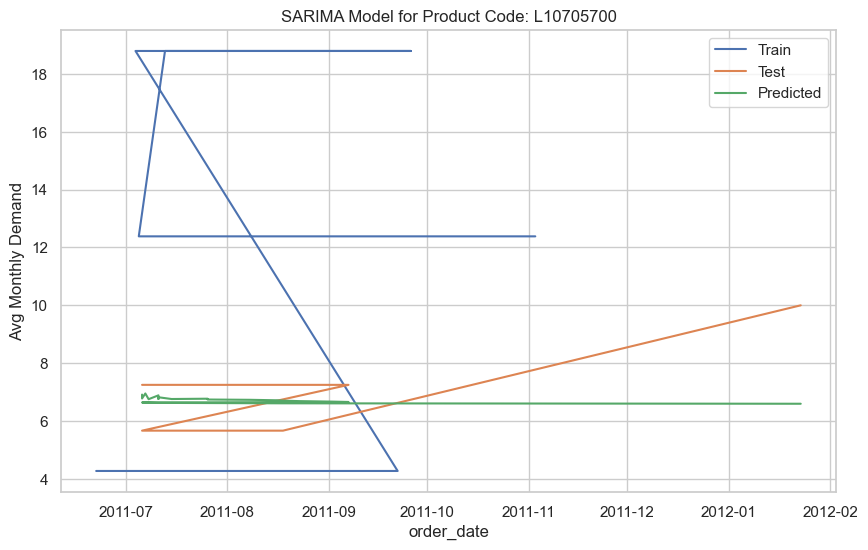

Model Summary for L10850600:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   52
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -36.511
Date:                Mon, 11 Dec 2023   AIC                             89.021
Time:                        17:16:42   BIC                            104.631
Sample:                             0   HQIC                            95.006
                                 - 52                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4789     86.125     -0.006      0.996    -169.281     168.323
ar.L2          0.5741     52.611      0.011      0.991    -102.541     103.689
ar.L3          0.9000  

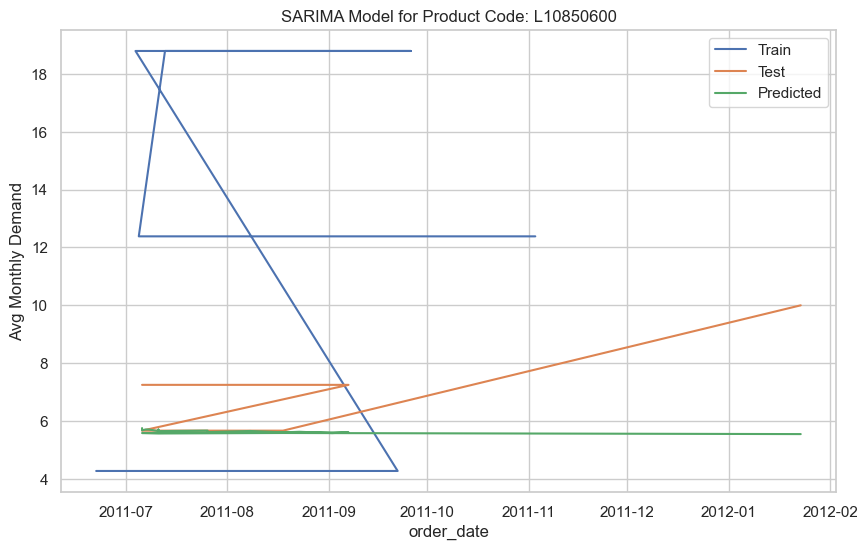

Model Summary for L10850700:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   11
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -12.266
Date:                Mon, 11 Dec 2023   AIC                             40.533
Time:                        17:16:42   BIC                             43.716
Sample:                             0   HQIC                            38.526
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7241    162.603      0.004      0.996    -317.972     319.420
ar.L2          0.8960    624.111      0.001      0.999   -1222.339    1224.131
ar.L3         -0.6287  

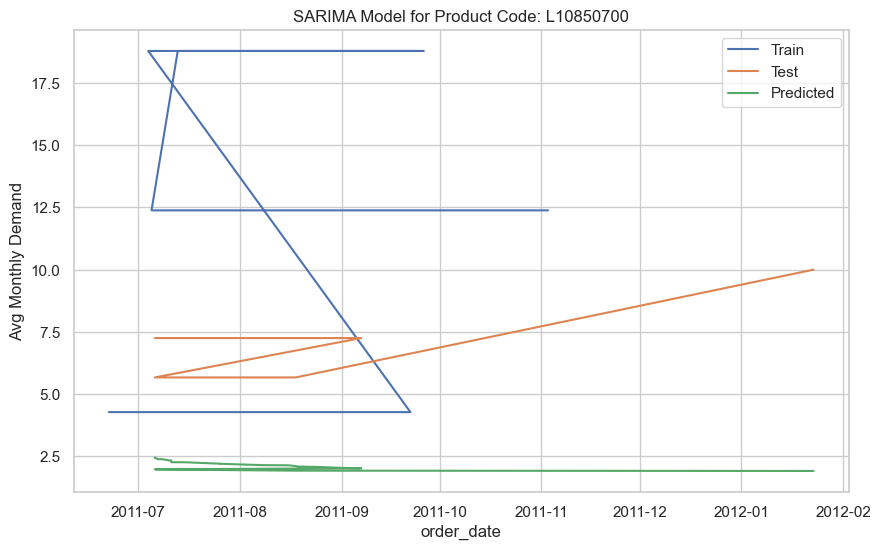

Model Summary for L10850800:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   35
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -131.549
Date:                Mon, 11 Dec 2023   AIC                            279.099
Time:                        17:16:42   BIC                            291.542
Sample:                             0   HQIC                           283.394
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9950      2.703      0.368      0.713      -4.304       6.294
ar.L2          0.0038      2.886      0.001      0.999      -5.653       5.660
ar.L3         -0.0044  

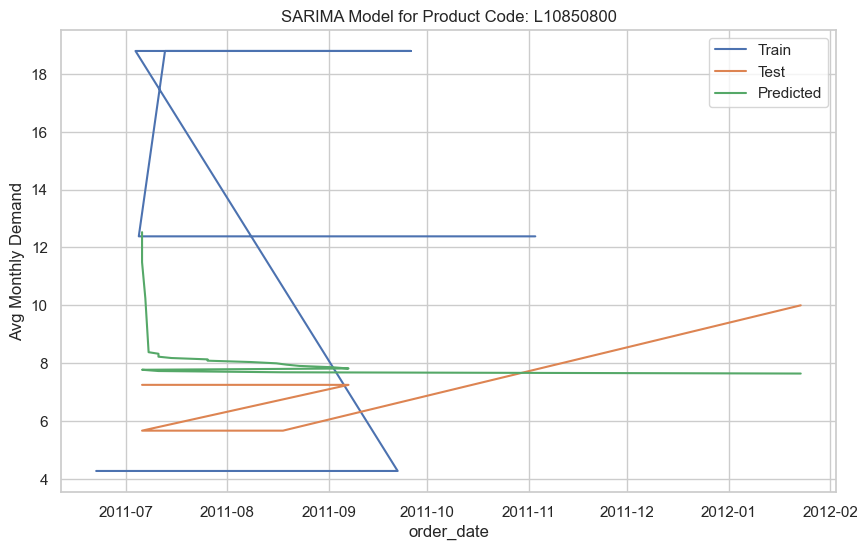

Model Summary for L10850900:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   20
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -19.217
Date:                Mon, 11 Dec 2023   AIC                             54.434
Time:                        17:16:43   BIC                             62.399
Sample:                             0   HQIC                            55.989
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4134      1.729     -0.239      0.811      -3.803       2.976
ar.L2          0.6955      5.622      0.124      0.902     -10.323      11.714
ar.L3          0.7127  

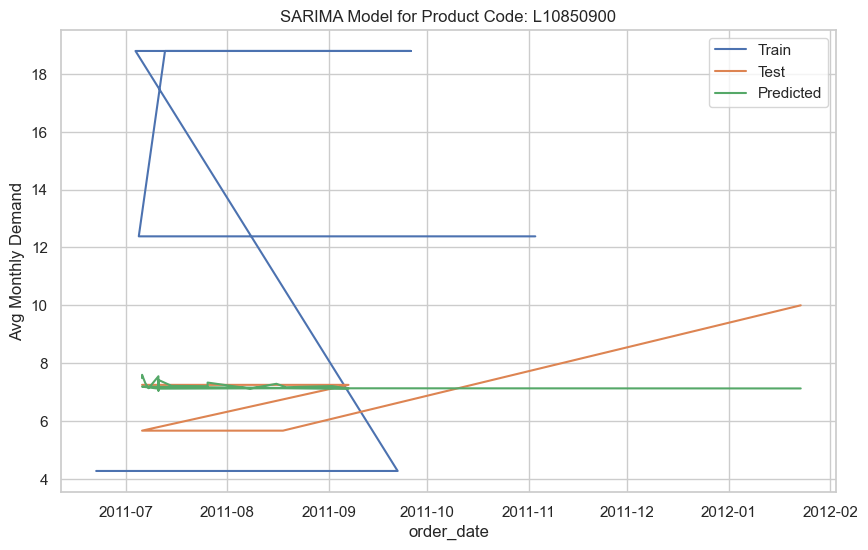

Model Summary for L10852800:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   35
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -19.495
Date:                Mon, 11 Dec 2023   AIC                             54.989
Time:                        17:16:43   BIC                             67.432
Sample:                             0   HQIC                            59.285
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3051      1.447      0.211      0.833      -2.531       3.141
ar.L2         -0.1508      1.605     -0.094      0.925      -3.297       2.996
ar.L3          0.8403  

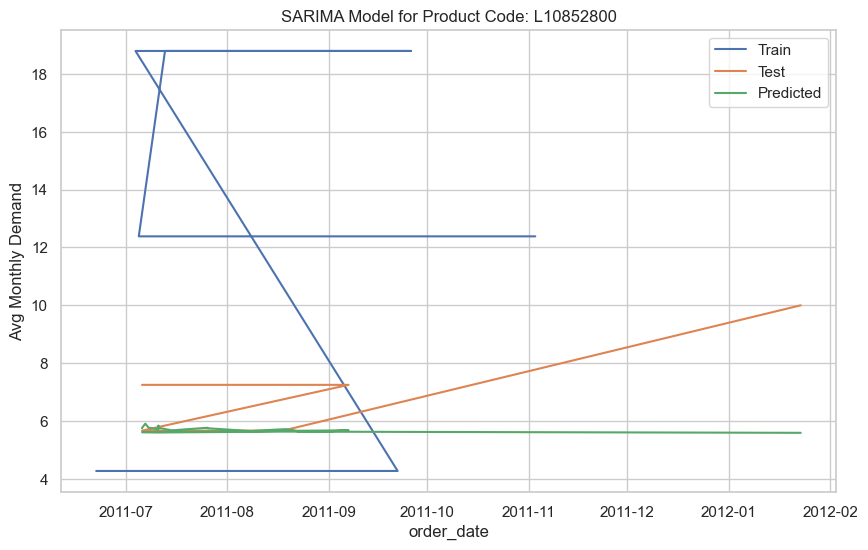

Model Summary for L10852900:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   25
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -113.066
Date:                Mon, 11 Dec 2023   AIC                            242.132
Time:                        17:16:43   BIC                            251.883
Sample:                             0   HQIC                           244.837
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9427     15.707      0.060      0.952     -29.842      31.727
ar.L2          0.0011      2.875      0.000      1.000      -5.634       5.637
ar.L3          0.0038  

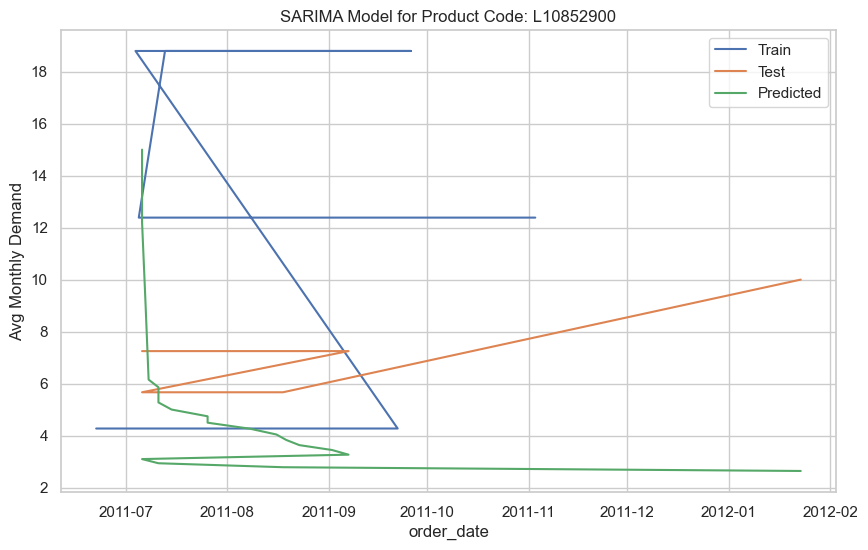

Model Summary for L10853100:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                    4
Model:               SARIMAX(3, 0, 4)   Log Likelihood                  17.769
Date:                Mon, 11 Dec 2023   AIC                            -19.538
Time:                        17:16:44   BIC                            -24.448
Sample:                             0   HQIC                           -30.312
                                  - 4                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9846      0.063    -15.664      0.000      -1.108      -0.861
ar.L2          0.9898      0.105      9.393      0.000       0.783       1.196
ar.L3          0.9948  

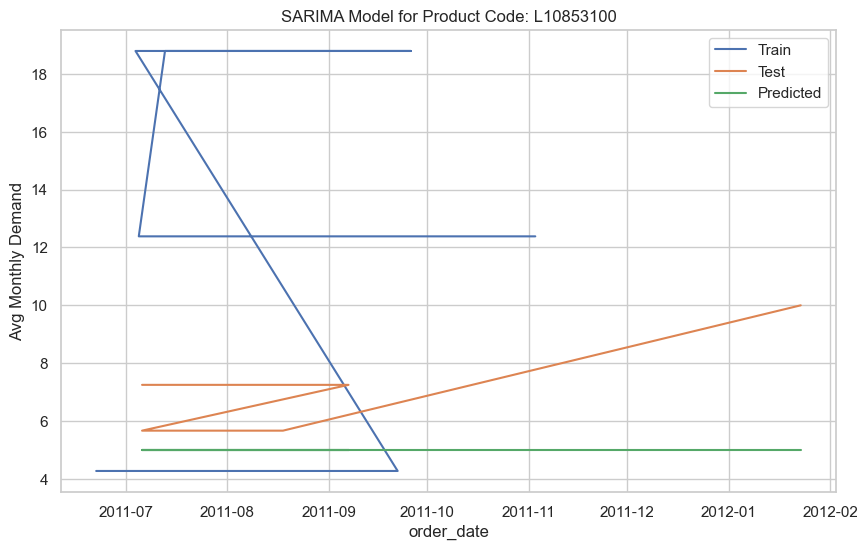

Model Summary for L12134400:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   65
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -56.371
Date:                Mon, 11 Dec 2023   AIC                            128.742
Time:                        17:16:44   BIC                            146.137
Sample:                             0   HQIC                           135.606
                                 - 65                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4537      5.668     -0.080      0.936     -11.563      10.656
ar.L2          0.6423      4.317      0.149      0.882      -7.818       9.103
ar.L3          0.8034  

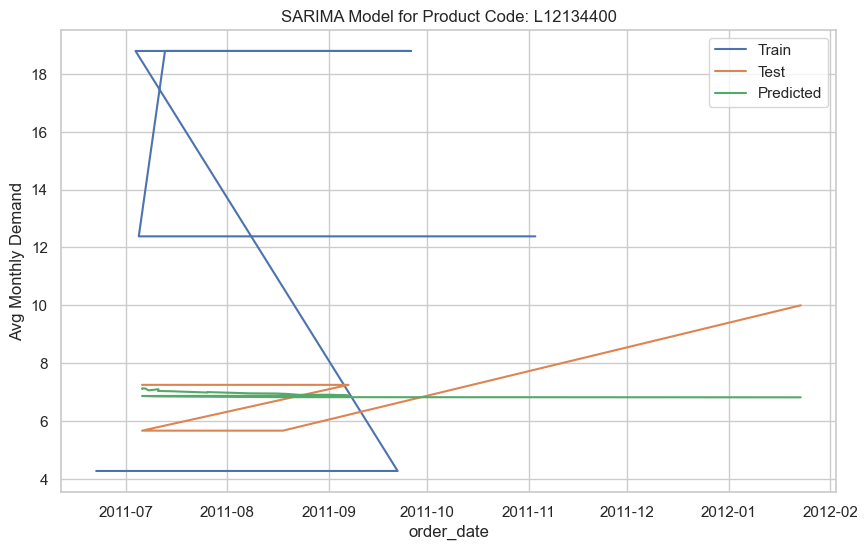

Model Summary for L12134500:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   32
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -52.674
Date:                Mon, 11 Dec 2023   AIC                            121.348
Time:                        17:16:44   BIC                            133.074
Sample:                             0   HQIC                           125.234
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0074      2.967      0.003      0.998      -5.808       5.823
ar.L2          0.7089      3.168      0.224      0.823      -5.500       6.918
ar.L3          0.2782  

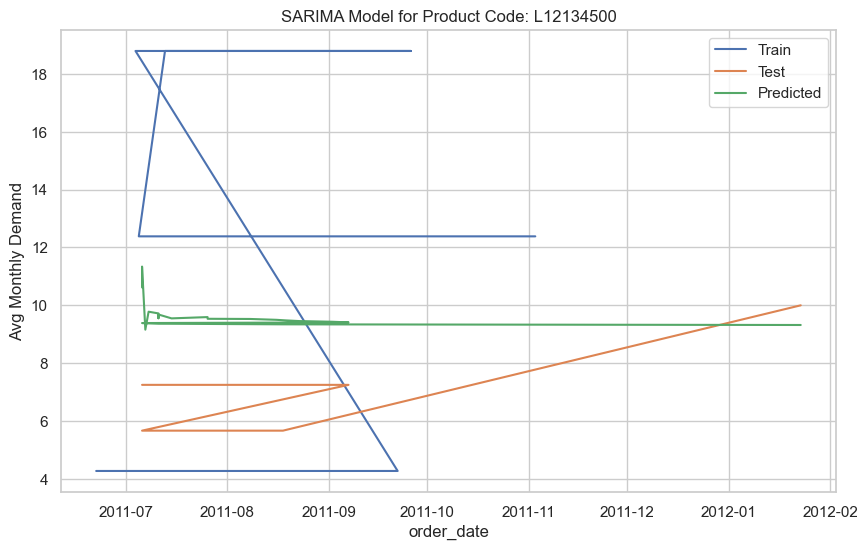

Model Summary for L12134600:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   41
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -138.000
Date:                Mon, 11 Dec 2023   AIC                            292.000
Time:                        17:16:44   BIC                            305.709
Sample:                             0   HQIC                           296.992
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1422     35.814      0.004      0.997     -70.051      70.335
ar.L2          0.8568      9.510      0.090      0.928     -17.782      19.496
ar.L3         -0.0642  

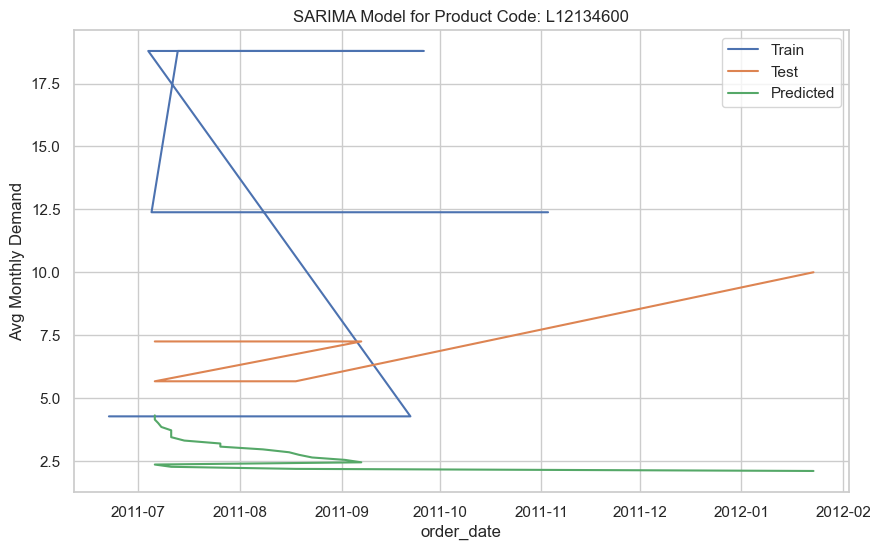

Model Summary for L12134700:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   20
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -11.843
Date:                Mon, 11 Dec 2023   AIC                             39.686
Time:                        17:16:45   BIC                             47.652
Sample:                             0   HQIC                            41.241
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1922      1.476     -0.130      0.896      -3.085       2.700
ar.L2          0.6187      0.722      0.857      0.392      -0.797       2.034
ar.L3          0.5689  

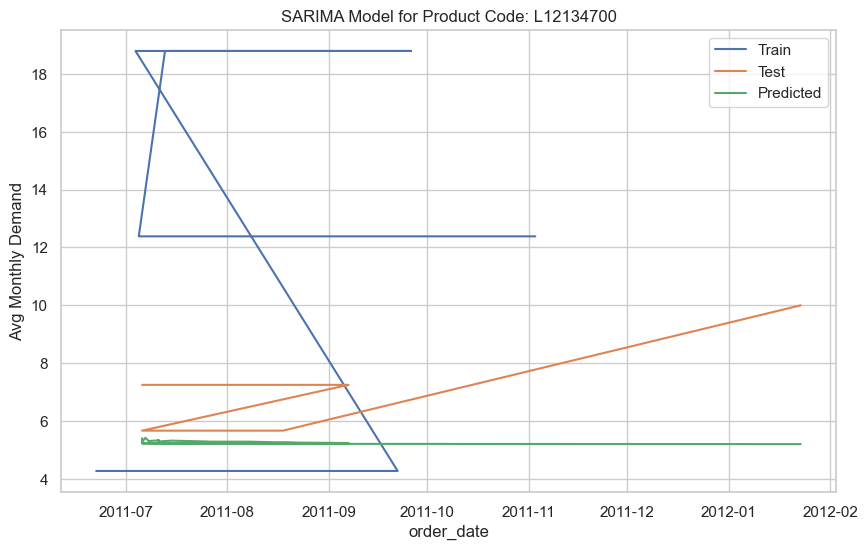

Model Summary for L12135800:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                  103
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -104.551
Date:                Mon, 11 Dec 2023   AIC                            225.103
Time:                        17:16:45   BIC                            246.180
Sample:                             0   HQIC                           233.640
                                - 103                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3122      4.789      0.065      0.948      -9.074       9.698
ar.L2          0.9551      6.212      0.154      0.878     -11.220      13.130
ar.L3         -0.2692  

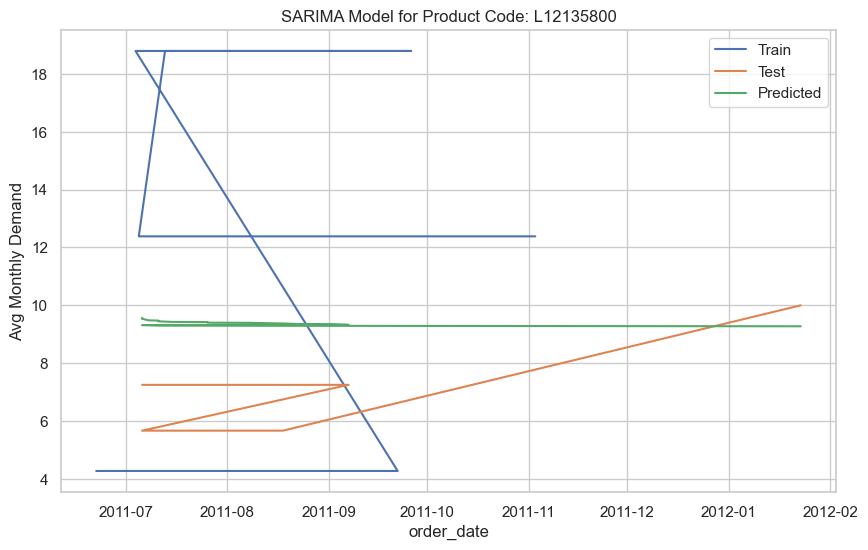

Model Summary for L12135900:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   41
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -20.127
Date:                Mon, 11 Dec 2023   AIC                             56.254
Time:                        17:16:46   BIC                             69.963
Sample:                             0   HQIC                            61.246
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0590      1.733      0.034      0.973      -3.337       3.455
ar.L2          0.4879      1.808      0.270      0.787      -3.056       4.032
ar.L3          0.4487  

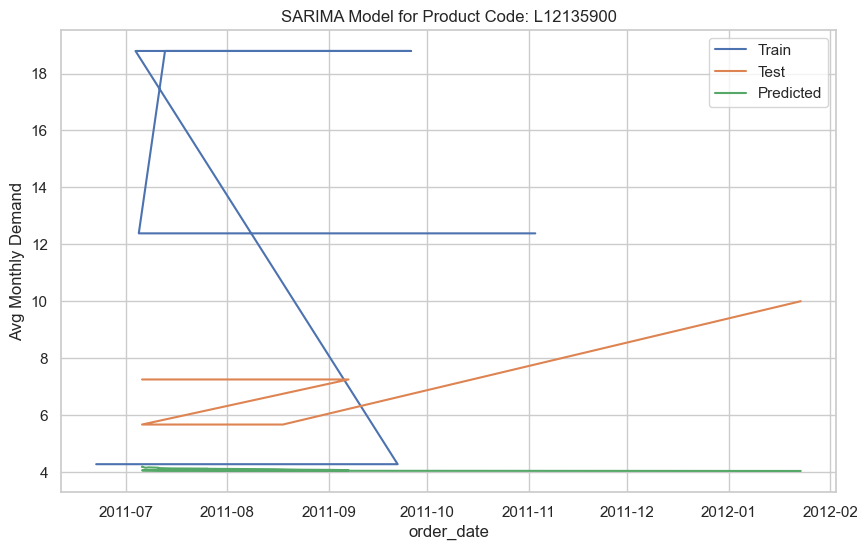

Model Summary for L12136000:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   32
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -13.353
Date:                Mon, 11 Dec 2023   AIC                             42.706
Time:                        17:16:46   BIC                             54.432
Sample:                             0   HQIC                            46.593
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4527      4.097     -0.110      0.912      -8.483       7.578
ar.L2          0.7011      3.168      0.221      0.825      -5.508       6.910
ar.L3          0.7410  

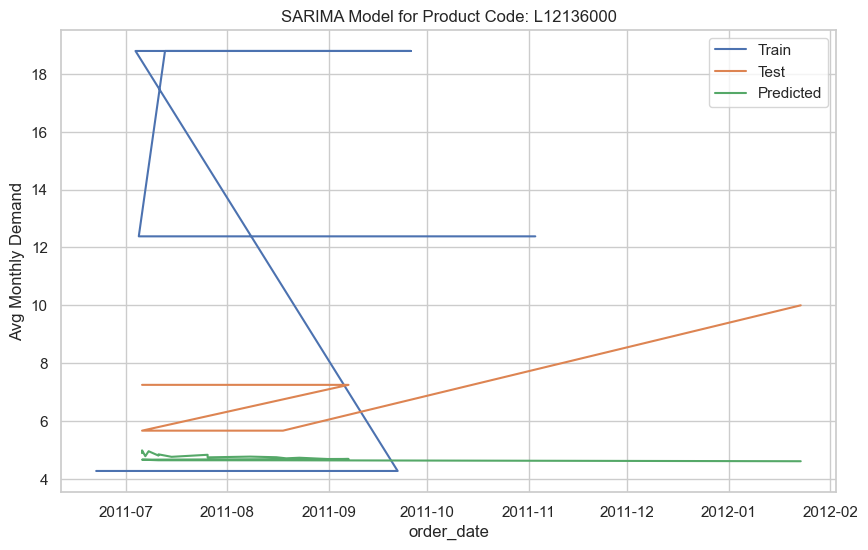

Model Summary for L12136100:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   75
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -21.714
Date:                Mon, 11 Dec 2023   AIC                             59.427
Time:                        17:16:46   BIC                             77.967
Sample:                             0   HQIC                            66.830
                                 - 75                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4004      9.323     -0.043      0.966     -18.674      17.873
ar.L2          0.7379     11.266      0.065      0.948     -21.343      22.818
ar.L3          0.6589  

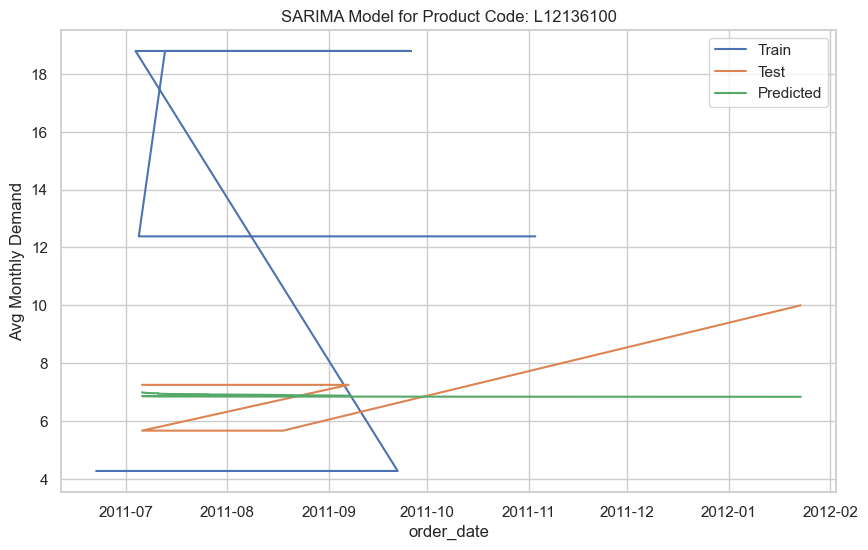

Model Summary for L12916800:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   35
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -22.292
Date:                Mon, 11 Dec 2023   AIC                             60.583
Time:                        17:16:47   BIC                             73.026
Sample:                             0   HQIC                            64.879
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3655   1076.022      0.000      1.000   -2108.598    2109.329
ar.L2          0.2916   1415.313      0.000      1.000   -2773.670    2774.253
ar.L3          0.3393  

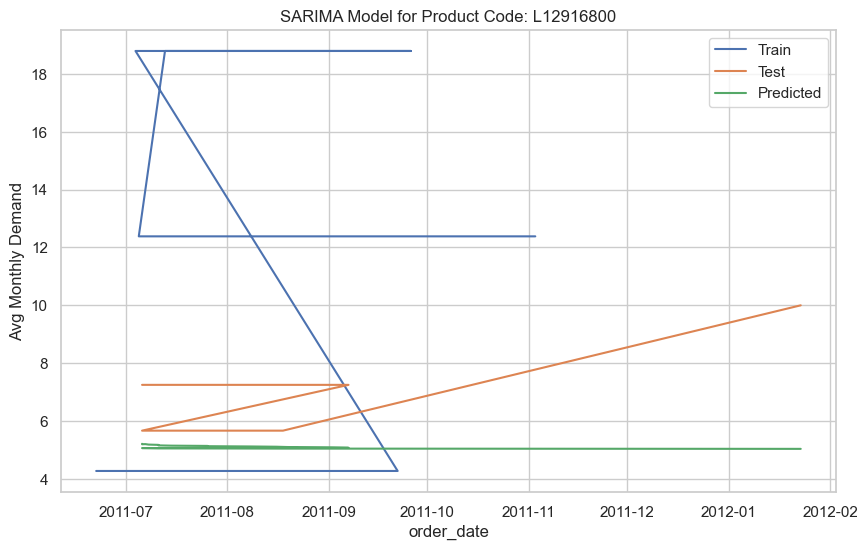

Model Summary for L12916900:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   96
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 227.893
Date:                Mon, 11 Dec 2023   AIC                           -439.786
Time:                        17:16:47   BIC                           -419.272
Sample:                             0   HQIC                          -431.494
                                 - 96                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9355      0.250     -3.737      0.000      -1.426      -0.445
ar.L2          0.9612      0.173      5.556      0.000       0.622       1.300
ar.L3          0.9743  

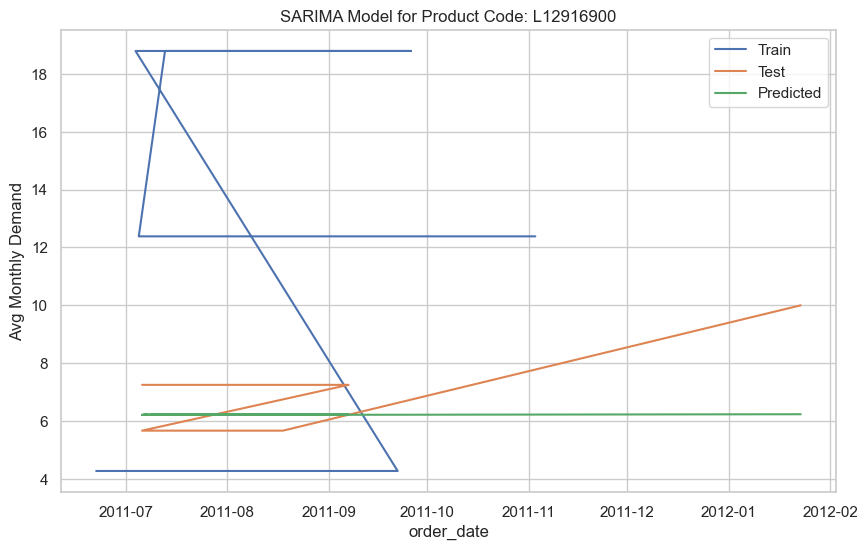

Model Summary for L12917000:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   20
Model:               SARIMAX(3, 0, 4)   Log Likelihood                  -3.321
Date:                Mon, 11 Dec 2023   AIC                             22.642
Time:                        17:16:47   BIC                             30.608
Sample:                             0   HQIC                            24.197
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0377      3.471      0.299      0.765      -5.765       7.841
ar.L2         -0.8970      3.291     -0.273      0.785      -7.347       5.553
ar.L3          0.8592  

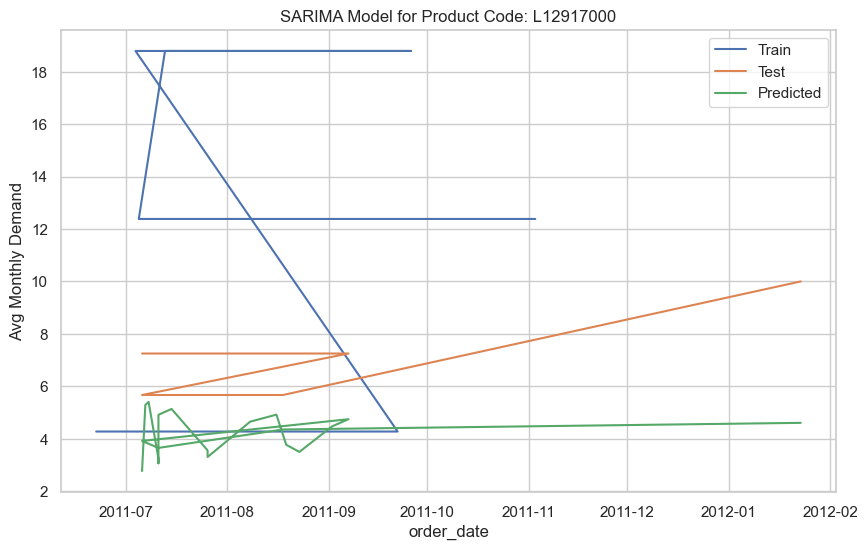

Model Summary for L12917100:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   12
Model:               SARIMAX(3, 0, 4)   Log Likelihood                   2.228
Date:                Mon, 11 Dec 2023   AIC                             11.544
Time:                        17:16:48   BIC                             15.423
Sample:                             0   HQIC                            10.107
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6030   1.79e+04  -3.38e-05      1.000    -3.5e+04     3.5e+04
ar.L2          0.7786   4.11e+04   1.89e-05      1.000   -8.06e+04    8.06e+04
ar.L3          0.8226  

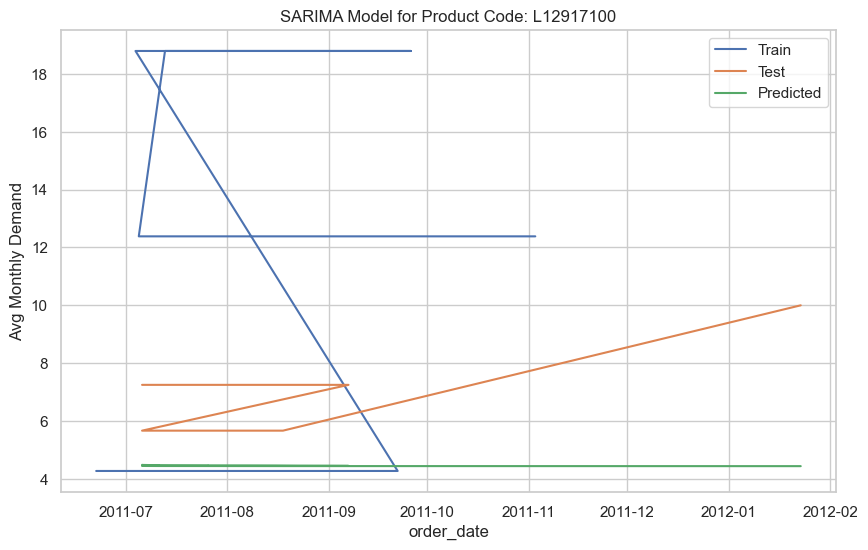

Model Summary for L12917700:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   52
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -42.160
Date:                Mon, 11 Dec 2023   AIC                            100.319
Time:                        17:16:48   BIC                            115.929
Sample:                             0   HQIC                           106.304
                                 - 52                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4989      2.731     -0.183      0.855      -5.851       4.853
ar.L2          0.5059      1.948      0.260      0.795      -3.312       4.324
ar.L3          0.9783  

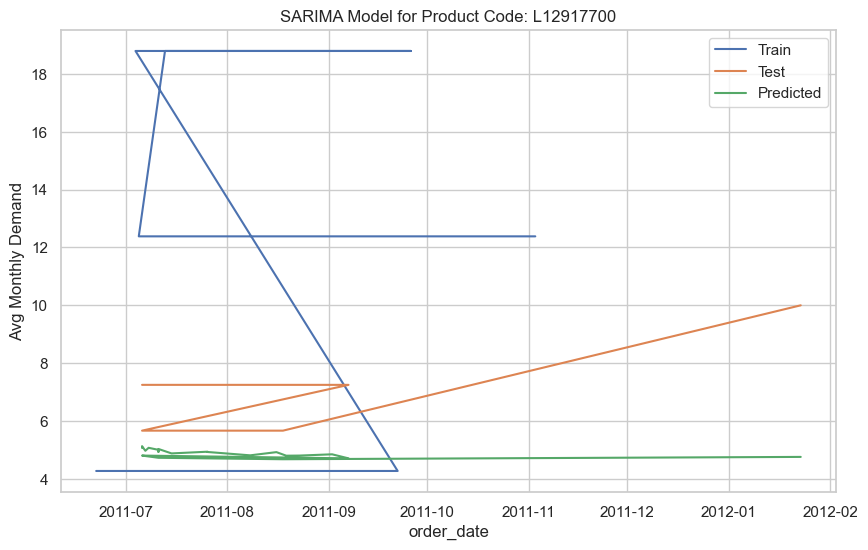

Model Summary for L12917800:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   48
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -123.018
Date:                Mon, 11 Dec 2023   AIC                            262.037
Time:                        17:16:48   BIC                            277.006
Sample:                             0   HQIC                           267.694
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1226      1.107     -0.111      0.912      -2.293       2.048
ar.L2          0.2805      0.857      0.327      0.744      -1.400       1.961
ar.L3          0.7508  

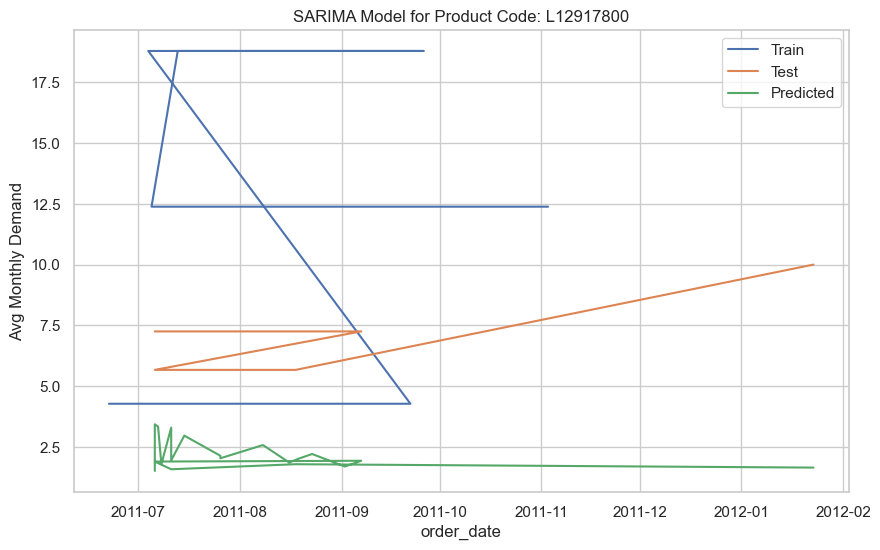

Model Summary for L12917900:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   84
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -106.735
Date:                Mon, 11 Dec 2023   AIC                            229.469
Time:                        17:16:49   BIC                            248.916
Sample:                             0   HQIC                           237.287
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5699      5.272     -0.108      0.914     -10.904       9.764
ar.L2          0.6605      7.368      0.090      0.929     -13.781      15.102
ar.L3          0.9011  

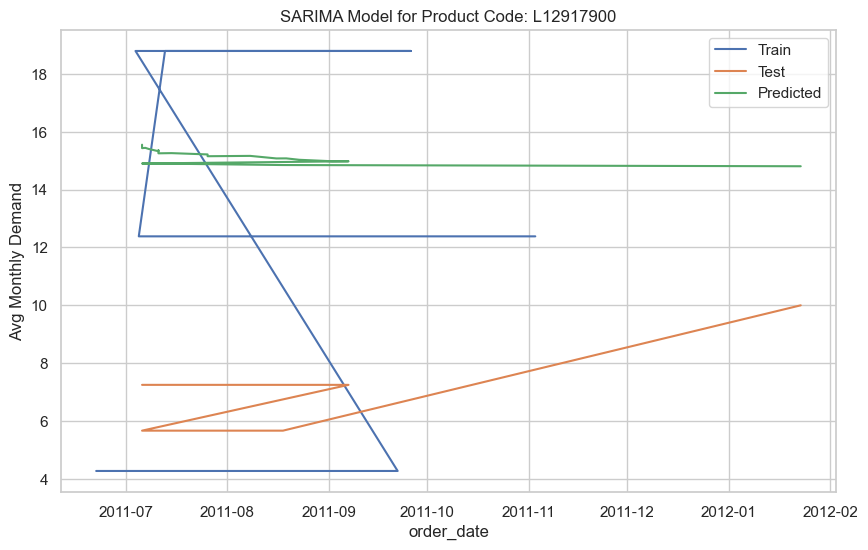

Model Summary for L12918000:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   62
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -178.300
Date:                Mon, 11 Dec 2023   AIC                            372.600
Time:                        17:16:49   BIC                            389.618
Sample:                             0   HQIC                           379.282
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2668     61.123      0.004      0.997    -119.532     120.065
ar.L2          0.2239     69.700      0.003      0.997    -136.386     136.834
ar.L3          0.4146  

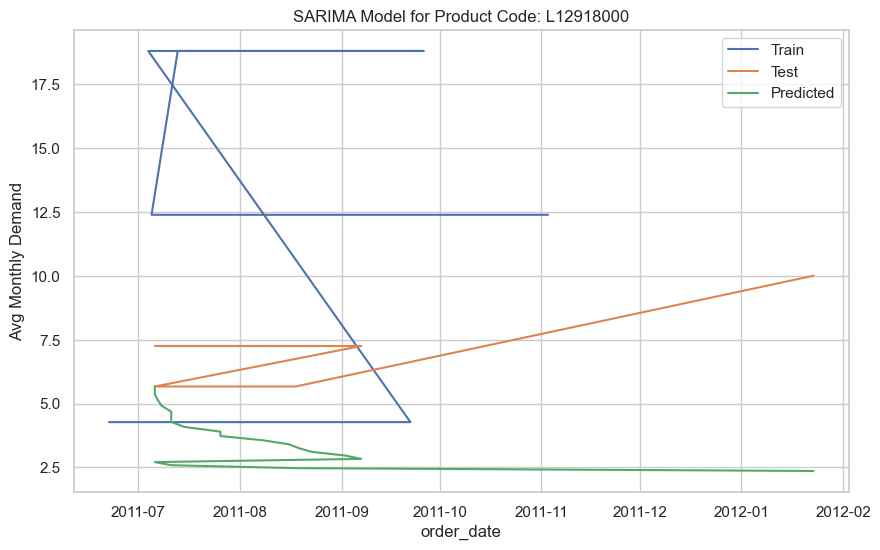

Model Summary for L12918400:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   88
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -140.197
Date:                Mon, 11 Dec 2023   AIC                            296.393
Time:                        17:16:49   BIC                            316.212
Sample:                             0   HQIC                           304.378
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2048    989.329     -0.000      1.000   -1939.254    1938.844
ar.L2          0.5008    764.647      0.001      0.999   -1498.180    1499.181
ar.L3          0.6815  

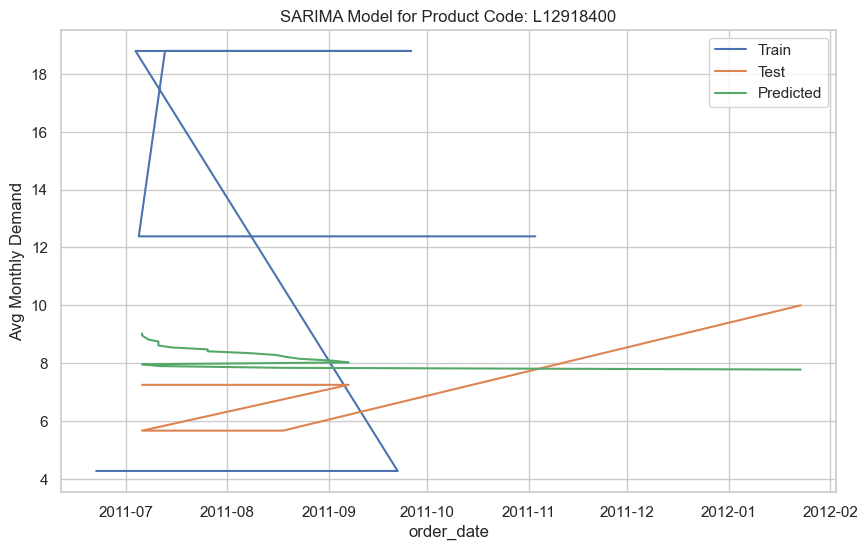

Model Summary for L12918500:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   68
Model:               SARIMAX(3, 0, 4)   Log Likelihood                  12.626
Date:                Mon, 11 Dec 2023   AIC                             -9.253
Time:                        17:16:49   BIC                              8.504
Sample:                             0   HQIC                            -2.217
                                 - 68                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6620      1.777     -0.373      0.709      -4.144       2.820
ar.L2          0.7190      0.776      0.927      0.354      -0.802       2.240
ar.L3          0.9424  

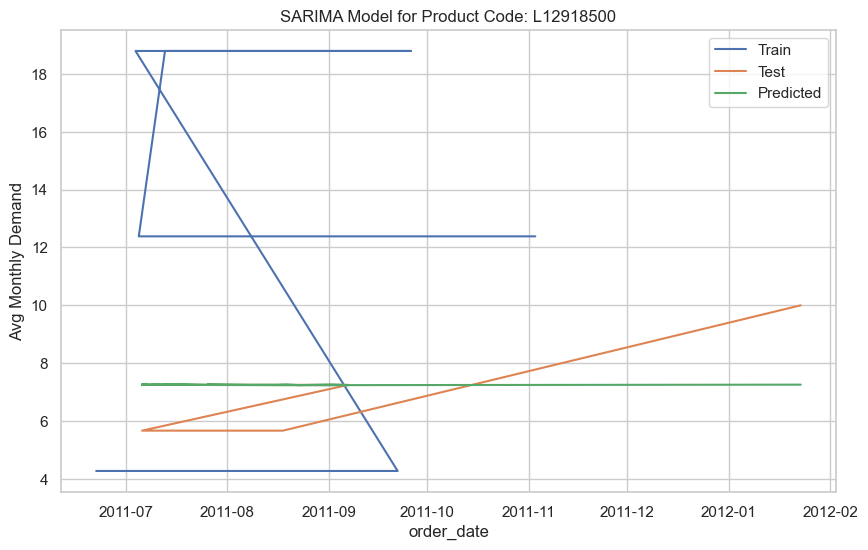

Model Summary for L12918600:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   48
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -56.903
Date:                Mon, 11 Dec 2023   AIC                            129.806
Time:                        17:16:50   BIC                            144.775
Sample:                             0   HQIC                           135.463
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2421     38.378      0.006      0.995     -74.977      75.461
ar.L2          0.8528      4.427      0.193      0.847      -7.825       9.530
ar.L3         -0.0973  

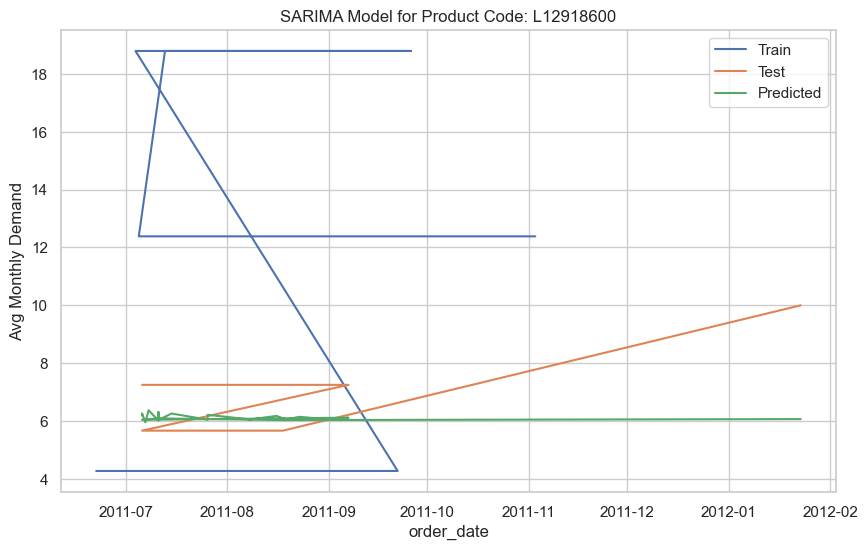

Model Summary for L12918700:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   83
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -24.859
Date:                Mon, 11 Dec 2023   AIC                             65.717
Time:                        17:16:50   BIC                             85.068
Sample:                             0   HQIC                            73.491
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5990      0.651     -0.920      0.358      -1.876       0.678
ar.L2          0.6939      0.514      1.350      0.177      -0.314       1.701
ar.L3          0.9034  

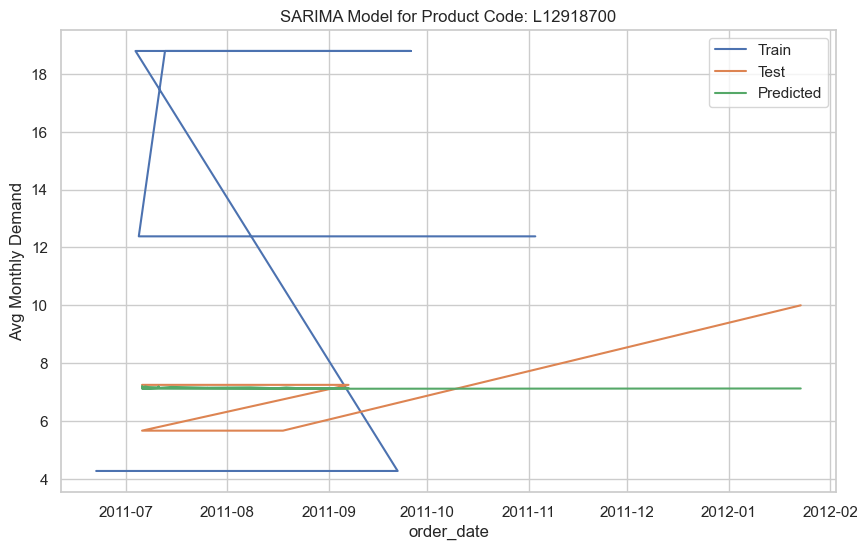

Model Summary for L12918800:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   24
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -28.028
Date:                Mon, 11 Dec 2023   AIC                             72.056
Time:                        17:16:50   BIC                             81.480
Sample:                             0   HQIC                            74.556
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0806      3.672     -0.022      0.982      -7.278       7.117
ar.L2          0.1808      4.441      0.041      0.968      -8.523       8.885
ar.L3          0.8752  

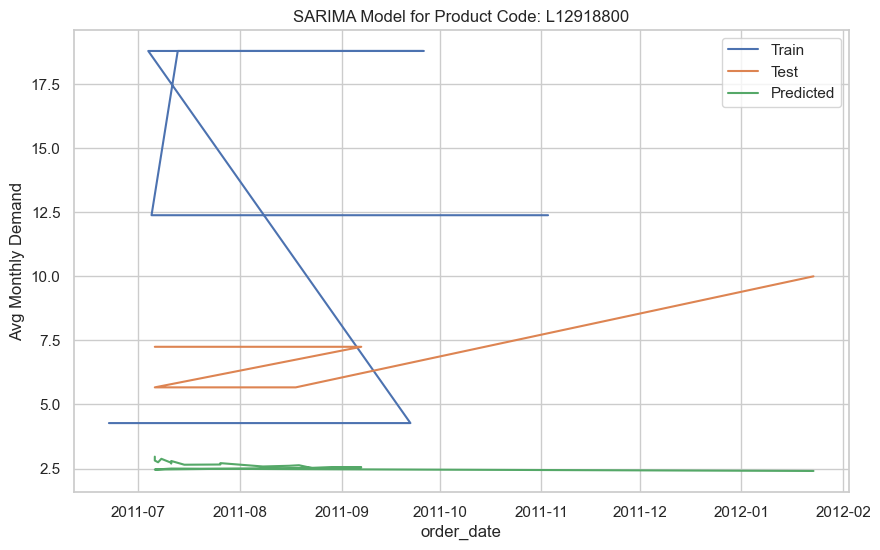

Model Summary for L12918900:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   43
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -18.662
Date:                Mon, 11 Dec 2023   AIC                             53.325
Time:                        17:16:51   BIC                             67.414
Sample:                             0   HQIC                            58.520
                                 - 43                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0532      4.570      0.012      0.991      -8.904       9.010
ar.L2          0.9867      0.367      2.691      0.007       0.268       1.705
ar.L3         -0.0400  

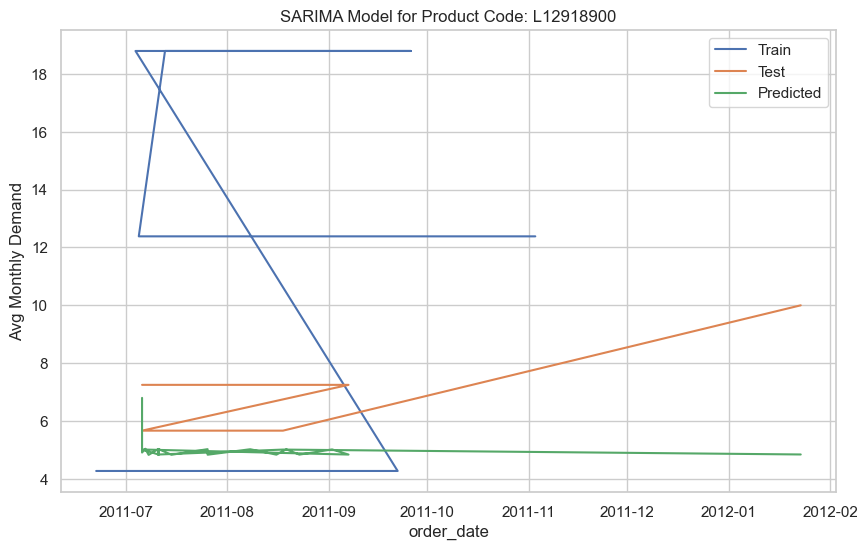

Model Summary for L12919000:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   73
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -28.900
Date:                Mon, 11 Dec 2023   AIC                             73.799
Time:                        17:16:51   BIC                             92.123
Sample:                             0   HQIC                            81.101
                                 - 73                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3139      0.984     -0.319      0.750      -2.242       1.614
ar.L2          0.5393      0.371      1.454      0.146      -0.188       1.266
ar.L3          0.7715  

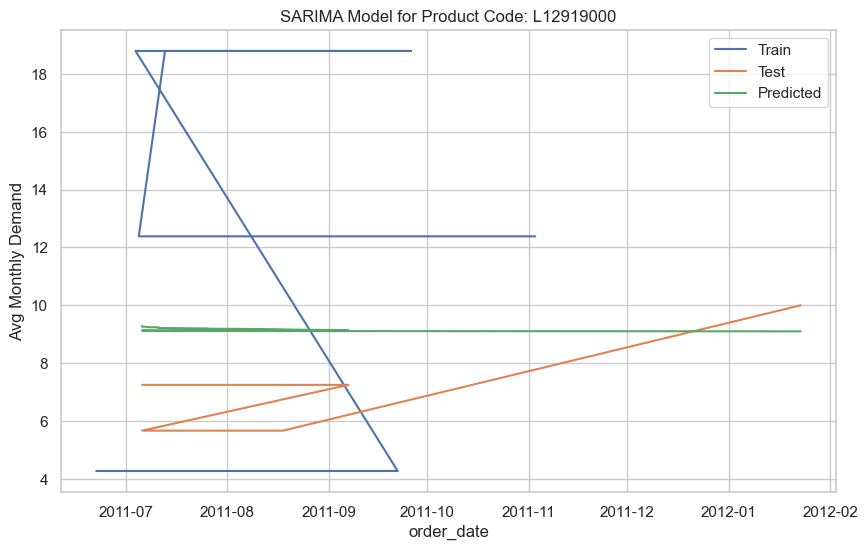

Model Summary for L12919100:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   31
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 -32.626
Date:                Mon, 11 Dec 2023   AIC                             81.251
Time:                        17:16:51   BIC                             92.723
Sample:                             0   HQIC                            84.991
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2799      2.056     -0.136      0.892      -4.310       3.750
ar.L2          0.8091      0.778      1.040      0.298      -0.715       2.334
ar.L3          0.4443  

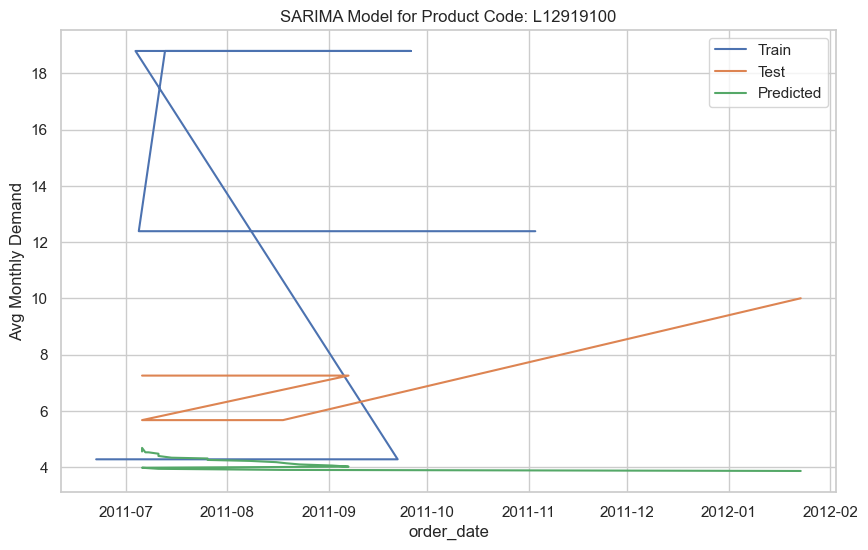

Model Summary for L12919200:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                   80
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -161.447
Date:                Mon, 11 Dec 2023   AIC                            338.894
Time:                        17:16:51   BIC                            357.950
Sample:                             0   HQIC                           346.534
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1123    316.790     -0.000      1.000    -621.009     620.784
ar.L2          0.4428    291.165      0.002      0.999    -570.231     571.117
ar.L3          0.6363  

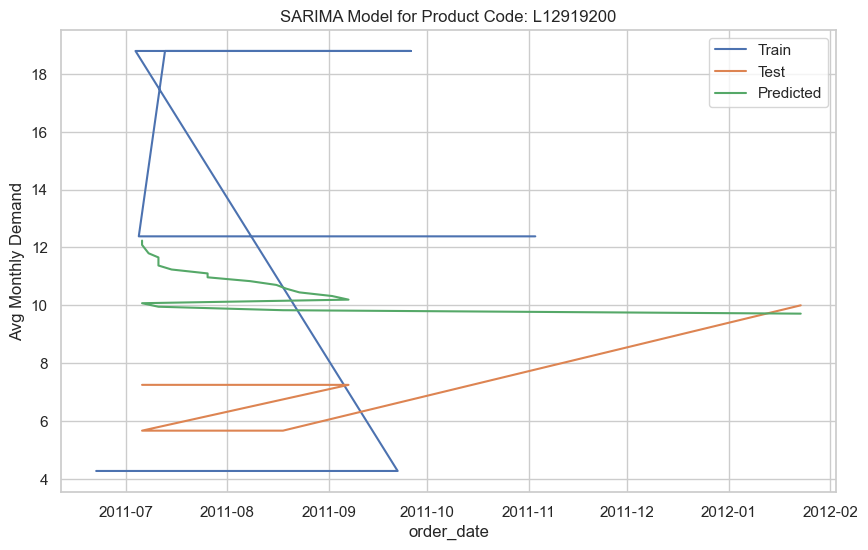

In [217]:
# Loop through the stored models for evaluation
for model_info in sarima_models:
    product_code = model_info['Product Code']
    sarima_fit = model_info['Model']
    
    # Make predictions on the test set
    predictions = sarima_fit.get_forecast(steps=len(test_data))

    # Print model summary
    print(f"Model Summary for {product_code}:\n{sarima_fit.summary()}\n")
    warnings.filterwarnings('ignore')
        
    # Evaluate the model
    mse = mean_squared_error(test_data['Avg Monthly Demand'], predictions.predicted_mean)
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error for {product_code}: {rmse}')
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(train_data['order_date'], train_data['Avg Monthly Demand'], label='Train')
    plt.plot(test_data['order_date'], test_data['Avg Monthly Demand'], label='Test')
    plt.plot(test_data['order_date'], predictions.predicted_mean, label='Predicted')
    plt.title(f'SARIMA Model for Product Code: {product_code}')
    plt.xlabel('order_date')
    plt.ylabel('Avg Monthly Demand')
    plt.legend()
    plt.show()


We will analyse the results of just one model -

**SARIMA Model Performance Analysis for Product Code L10850900:**

The SARIMA model for Product Code L10850900 was evaluated based on historical data, providing valuable insights into its performance.

- **Root Mean Squared Error (RMSE):** The RMSE is a measure of the model's prediction accuracy. For L10850900, the RMSE is approximately 0.873, indicating a reasonable level of accuracy in forecasting the average monthly demand.

- **Log Likelihood:** The log likelihood measures how well the model explains the observed data. In this case, the log likelihood is -19.217, suggesting that the model provides a reasonable fit to the historical data for L10850900.

- **Ljung-Box (L1) (Q):** The Ljung-Box test checks for autocorrelation in the model's residuals. A Q-statistic close to 0 indicates no significant autocorrelation. Here, the Q-statistic is 0.01, suggesting limited autocorrelation in the residuals.

- **Jarque-Bera (JB):** The Jarque-Bera test assesses the normality of the residuals. A low p-value indicates departure from normality. In this case, the p-value is 0.00, suggesting potential non-normality in the residuals.

**Overall Model Performance:**
The SARIMA model for L10850900 demonstrates reasonable accuracy in predicting the average monthly demand. The log likelihood and autocorrelation tests indicate a good fit to historical data, although the Jarque-Bera test suggests potential non-normality in residuals.

**Business Implications:**

1. **Accurate Demand Prediction:** With a low RMSE of approximately 0.873, the model provides accurate forecasts for the average monthly demand of Product Code L10850900. This accuracy supports effective inventory management and operational planning.

2. **Model Fit:** The negative log likelihood value of -19.217 indicates a reasonable fit of the model to historical data, enabling businesses to rely on the model for demand forecasting.

3. **Autocorrelation Assessment:** The Ljung-Box test results (Q-statistic of 0.01) suggest limited autocorrelation in the model's residuals, ensuring that predictions are not biased by past patterns.

4. **Residual Normality:** The Jarque-Bera test indicates potential non-normality in the residuals. Businesses should be aware of any non-normal distribution, and further investigation or adjustments may be considered for robust forecasting.

5. **Decision Support:** Stakeholders can use the SARIMA model outputs to make informed decisions related to production, supply chain, and resource allocation for Product Code L10850900. The model provides a reliable foundation for strategic planning.

In conclusion, the SARIMA model for Product Code L10850900 offers businesses a tool for accurate demand forecasting, contributing to improved operational efficiency and strategic decision-making. Continuous monitoring and refinement will further enhance the model's effectiveness over time.


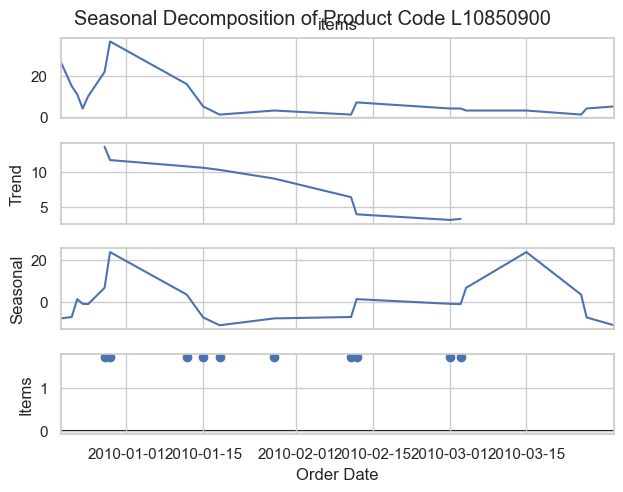

20    4.520423
21    3.328546
22    4.360029
23    3.433374
24    4.067851
25    3.273238
26    3.834939
27    3.113248
28    3.616994
29    2.960241
Name: predicted_mean, dtype: float64


In [236]:
# Example usage of one model

from statsmodels.tsa.seasonal import seasonal_decompose

# Selecting a single product category for demonstration
sample_product_data = df[df['Product Code'] == 'L10850900']

# Grouping by order_date and summing the items
sample_product_data_grouped = sample_product_data.groupby('order_date')['items'].sum()

# Set the seasonal period for decomposition
period = 10

# Check if data is available for the selected product code
if not sample_product_data_grouped.empty:
    
    # Sort the data by order_date for better visualization
    sample_product_data_grouped = sample_product_data_grouped.sort_index()

    # Seasonal decomposition of the time series data
    decomposition = seasonal_decompose(sample_product_data_grouped, model='additive', period=period)
    
    # Plot the decomposition components
    decomposition.plot()
    
    # Add title and labels to the plot
    plt.suptitle('Seasonal Decomposition of Product Code L10850900')
    plt.xlabel('Order Date')
    plt.ylabel('Items')
    
    # Display the plot
    plt.show()

    # Initialize and train the SARIMA model
    model = SARIMAX(sample_product_data_grouped, order=(3, 0, 4), seasonal_order=(0, 0, 0, 12))
    results = model.fit()

    # Forecast the next 10 steps
    forecast = results.get_forecast(steps=10)
    forecast_values = forecast.predicted_mean
    
    # Print the forecasted values
    print(forecast_values)
    
else:
    print("No data available for the selected product code.")


**Interpreting SARIMA Model Forecast for Product Code L10850900**

The output presents the forecasted values for the next 10 time steps (months) for Product Code L10850900 based on the SARIMA model. Each value in the 'predicted_mean' column represents the estimated average quantity of items for a specific future time point.

- **Forecasted Values:**
  - Time Step 20: Estimated average of approximately 4.52 items.
  - Time Step 21: Estimated average of approximately 3.33 items.
  - Time Step 22: Estimated average of approximately 4.36 items.
  - Time Step 23: Estimated average of approximately 3.43 items.
  - Time Step 24: Estimated average of approximately 4.07 items.
  - Time Step 25: Estimated average of approximately 3.27 items.
  - Time Step 26: Estimated average of approximately 3.83 items.
  - Time Step 27: Estimated average of approximately 3.11 items.
  - Time Step 28: Estimated average of approximately 3.62 items.
  - Time Step 29: Estimated average of approximately 2.96 items.

**Business Insights:**
1. **Demand Forecasting:** The model provides valuable insights into the expected demand for Product Code L10850900 over the next 10 months. Businesses can utilize these forecasts to plan inventory levels, production schedules, and resource allocation.

2. **Trend Analysis:** Observing the trend in forecasted values allows businesses to identify potential increases or decreases in demand. For instance, a rising trend might indicate growing demand, influencing decisions related to production and stocking.

3. **Resource Planning:** The forecasted values guide businesses in optimizing resource allocation. Whether it's staffing, raw materials, or storage space, accurate predictions contribute to efficient resource management.

4. **Operational Efficiency:** By aligning operations with anticipated demand, businesses can minimize the risk of overstocking or stockouts. This enhances overall operational efficiency and customer satisfaction.

5. **Decision Support:** The forecasted values serve as a basis for strategic decision-making. Business stakeholders can make informed choices regarding marketing campaigns, promotions, and sales initiatives.
